# code to calculate dN/dz and dN/dX from sensitivity function g(W,z)

In [1]:
import string
import numpy as np
import sys
import random
import itertools
from astropy.table import Table
from astropy.io import ascii

import matplotlib
import scipy.integrate as integ
import scipy.stats
import scipy.optimize as op
import scipy.special as sc
import scipy.odr as odr
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy.random as npr
# from pylab import *

from matplotlib.patches import Ellipse
from matplotlib.ticker import ScalarFormatter

# from stat_funcs import *

In [2]:
#constants here:

omega_m = 0.3
omega_l = 0.7
H0 = 70 #km/s/Mpc
c_kms = 3e5 #km/s

In [3]:
#define a function to find position of nearest EW to grid:

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [4]:
#import data:

# CIV_data = np.loadtxt("total_CIV.table",unpack=True,skiprows=1,usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17))

CIV_gwz = np.genfromtxt("gwz_uniques_3sigma.grid")

CIV_data = ascii.read("abs_info_new.txt",data_start=1)

Qso, Zabs, Ewr, Ewsig = CIV_data['QSO'], CIV_data['z_abs'], CIV_data['EW_r'],  CIV_data['EW_r_e']

logN, logN_l, logN_u = CIV_data['logN'], CIV_data['logN_l'], CIV_data['logN_u']

N_abs, N_abs_l, N_abs_u = 10**logN, 10**logN_l, 10**logN_u 

#QSO redshifts:

zem_data = ascii.read("qso_zems.txt",data_start=1)
Qso_zem, Zem = zem_data['QSO'], zem_data['zem']


#Cooksey+(2013):

CIV_Cooksey = ascii.read("cooksey_civabs.txt",data_start=1)
# QSO_Cooksey = ascii.read("cooksey_qsoinfo.txt",data_start=1)

Qsociv_c, Zabs_c, Ewr_c, Ewsig_c = CIV_Cooksey['z_QSO'], CIV_Cooksey['z_CIV'], CIV_Cooksey['W_1548'],  CIV_Cooksey['W_1548_e']


# Qso_c, Zqso_c, dXmax_c, Nabs_c = QSO_Cooksey['QSO'], QSO_Cooksey['z_QSO'], QSO_Cooksey['dXmax'],  QSO_Cooksey['N_CIV']





In [5]:
#EWlims:

ewlims_all = np.genfromtxt("ewlims_all.txt")

#remove negative values:

ewlim_all = ewlims_all[ewlims_all >= 0]

In [ ]:
# cumulative

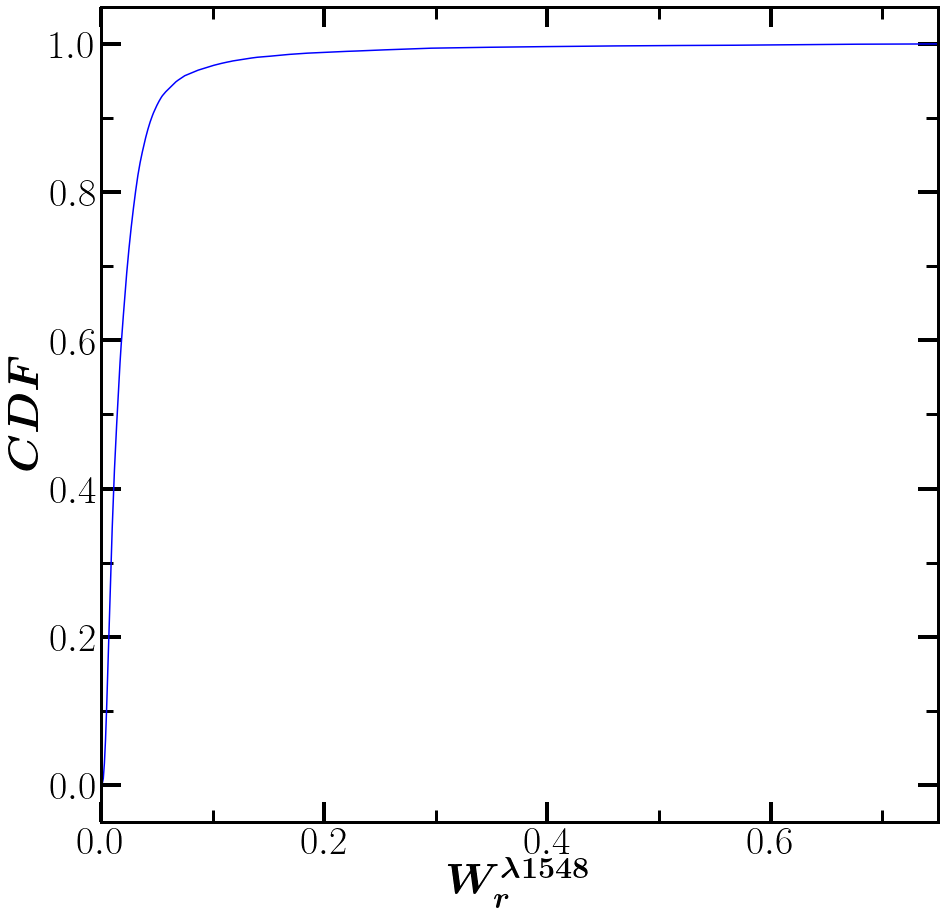

In [7]:
#cumulative histogram of EWlims:

fig, ax = plt.subplots(figsize=(15,15))


plt.rc("text", usetex=True)
# plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
# plt.rc('font', family='serif')

# matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=3)

values_cdf, base_cdf = np.histogram(ewlim_all, bins=1000, range=(0.,1.),density=True)
#evaluate the cumulative
cumulative = np.cumsum(values_cdf)
# plot the cumulative function
plt.plot(base_cdf[:-1], cumulative/1000, c='blue')


# plt.show()
# fig, ax = plt.subplots(figsize=(10, 10))

# # plot the cumulative histogram
# n_cdf, bins_cdf, patches_cdf = ax.hist(ewlim_all, 1000, density=True,
#                            cumulative=True)

# # Add a line showing the expected distribution.
# # y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
# #      np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# y = n_cdf.cumsum()
# # y /= y[-1]

# ax.plot(bins_cdf[:-1], y, 'k--', linewidth=1.5)

# # Overlay a reversed cumulative histogram.
# ax.hist(ewlim_all, bins=bins_cdf, density=True)

# tidy up the figure

plt.xlim(0,0.75)

ax.set_xlabel(r'\boldmath{$W^{\lambda1548}_{r}$}',fontsize=44)
ax.set_ylabel(r'\boldmath{$CDF$}',fontsize=44)

# ax.set_yscale('log')

ax.tick_params(axis='both', which='major', direction='in', labelsize=40,length=20, width=4, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=36,length=12, width=3, bottom='on',top='on', left='on', right='on')
ax.set_xticks(np.arange(0,0.8,0.1), minor=True)
ax.set_yticks(np.arange(0,1.1,0.1), minor=True)

# plt.savefig('EWlim_CDF.pdf')

plt.show()

In [287]:
# len(logN), len(logN[logN!=0.0])
# logN[43]

0.0

In [185]:
np.percentile(logN,100)

15.432

In [127]:
10**0.7

5.011872336272722

In [5]:
#population means:
mean_Zabs, mean_Ewr, mean_logN = np.mean(Zabs), np.mean(Ewr), np.mean(logN[logN!=0.0])
mean_Zem = np.mean(Zem)


#gwz grid params:

min_ewl, max_ewl, ewl_spacing = 0.005, 0.405, 0.005
min_CIV_z, max_CIV_z, z_spacing = 1.00, 5.00, 0.005

w_grid = np.arange(min_ewl, max_ewl, ewl_spacing) 

z_grid = np.arange(min_CIV_z,max_CIV_z,z_spacing)



#dN/dz grid params:

dz = 0.25
# zbins = np.arange(min_CIV_z, max_CIV_z,dz)

#redshift bins for dN/dz and dN/dX:

zbins_c = np.array([1.45, 1.61, 1.7, 1.78, 1.87, 1.96, 2.08, 2.24, 2.51, 2.97,4.55])
zbins = np.array([1.0, 1.5, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.1, 3.75,4.75])


#EQW bins for EWD:
# ewbins = np.array([0.01, 0.07, 0.15, 0.2, 0.3, 0.4, 0.6, 0.9, 1.5, 2.5, 4.0])
ewbins=np.logspace(-2.3,0.7,num=12)

#one EQW bin to rule them all:
ewbins_all = np.array([10**-2.3,10**0.7])

#N bins for CDD:
columnbins = np.logspace(12,15.5,num=12)
# np.array([1e12,5e12,1e13,2e13,3e13,4e13,6e13,8e13,1e14,2e14,4e14,8e14,3e15])

# EW_bins = np.array([0.01, 0.04, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.9,1.5,2.5,4.0])


#larger redshift bins for EWD and CDD:

zbins_large = np.array([1,2,3,4.75])

# lowz,midz,highz = 1,2,3

#one redshift bin to rule them all:

zbins_all = np.array([1,5])

#EQW cuts:

# weak, med, strong = 0.01, 0.3, 1.

vweak, weak, med, strong, vstrong = 0.01, 0.3, 0.7, 1.0, 1.2


In [467]:
np.percentile(Zabs,5),np.percentile(Zabs,25), np.percentile(Zabs,50), np.percentile(Zabs,75), np.percentile(Zabs,95)

(1.4806915600000001, 1.9814296, 2.4180188, 2.8703275, 3.5882730599999997)

In [884]:
ewbins_all

array([0.00501187, 5.01187234])

In [193]:
columnbins

array([1.00000000e+12, 2.08056754e+12, 4.32876128e+12, 9.00628020e+12,
       1.87381742e+13, 3.89860370e+13, 8.11130831e+13, 1.68761248e+14,
       3.51119173e+14, 7.30527154e+14, 1.51991108e+15, 3.16227766e+15])

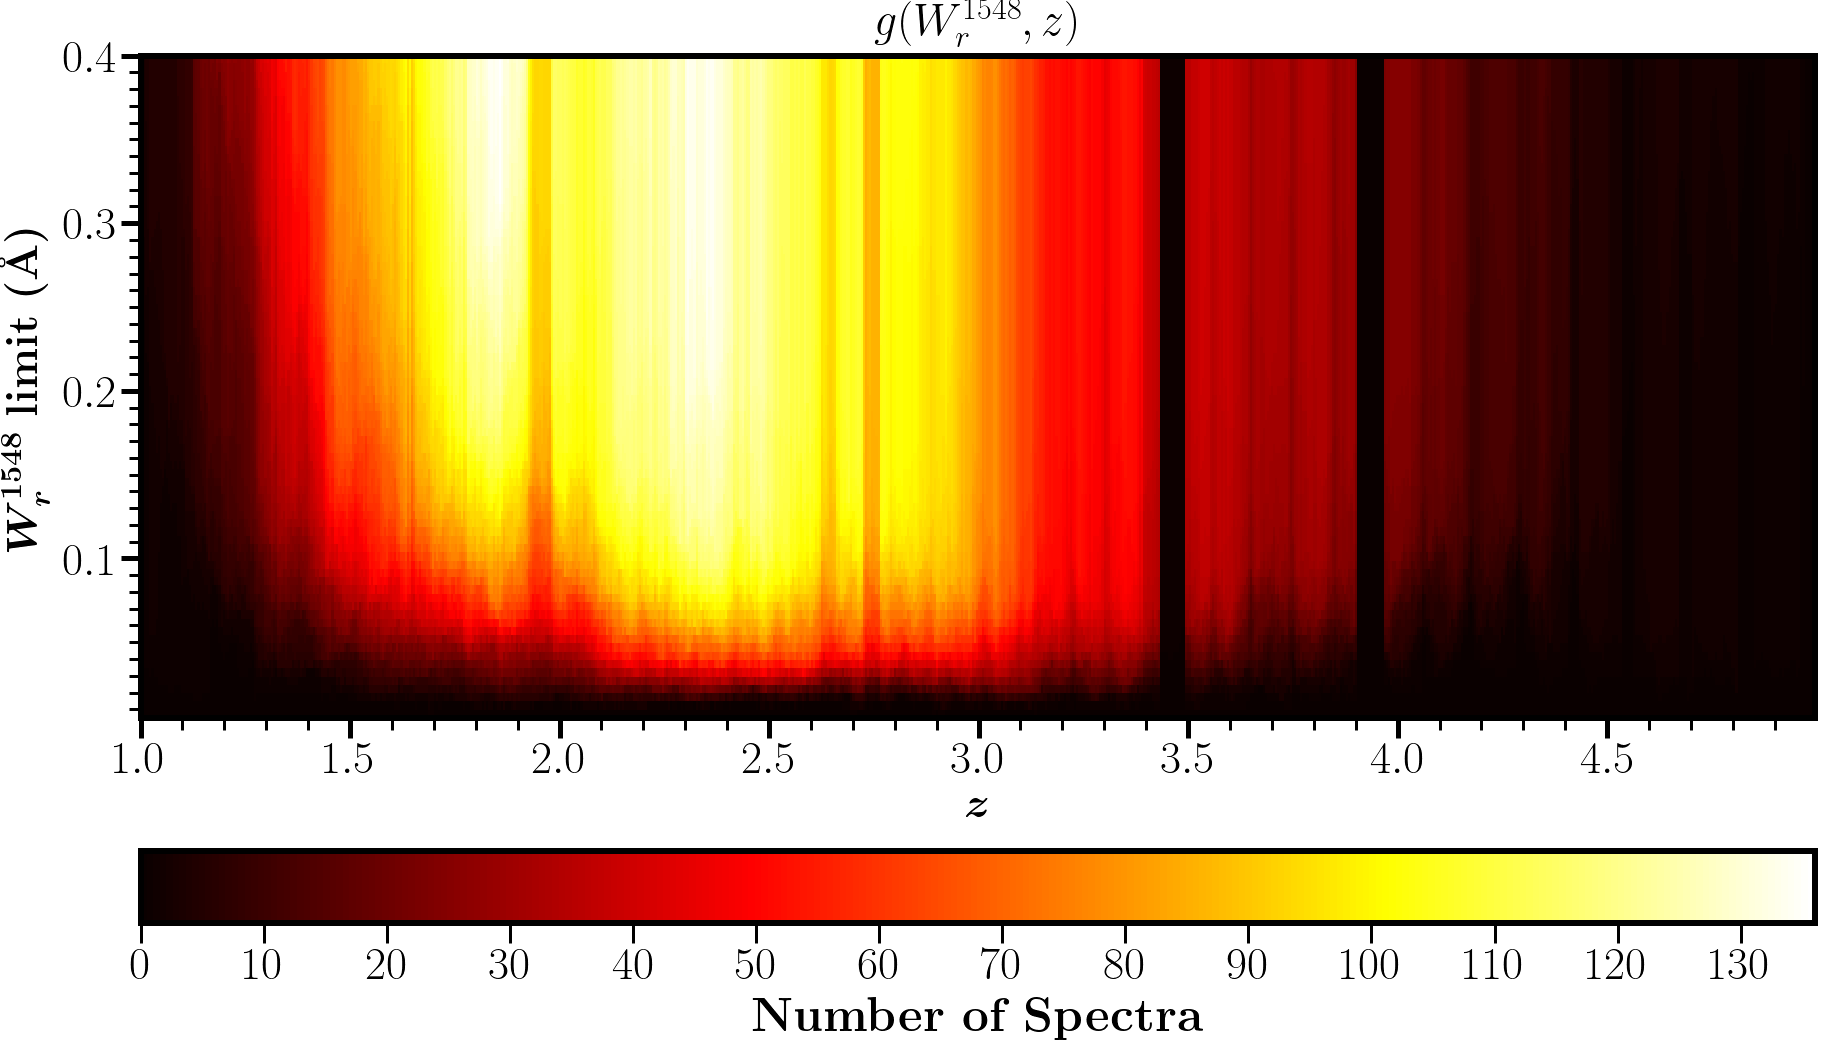

In [7]:
#Plot g(W,z) heat map:

fig, ax = plt.subplots(figsize=(30, 20))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rc('font', size=48) 
plt.rc('font', family='serif')

# matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)


plt1 = plt.imshow(CIV_gwz[::-1],extent=(min(z_grid),max(z_grid),min(w_grid),max(w_grid)),aspect=4,cmap='hot')
plt.title(r'\textbf{$g(W_r^{1548}, z)$}',fontsize=46)

ax.set_xlabel(r'\boldmath{$z$}',fontsize=44)
ax.set_ylabel(r'\boldmath{$W^{1548}_{r}$} \textbf{limit (\AA)}',fontsize=44)

ax.tick_params(axis='both', which='major', direction='out', labelsize=46,length=20, width=5, bottom='on', left='on')
ax.tick_params(axis='both', which='minor', direction='out', labelsize=46,length=12, width=3, bottom='on', left='on')


# ax[1].set_xscale('log')
ax.set_xticks(np.arange(1,5,0.1), minor=True)
ax.set_yticks(np.arange(0.,0.4,0.01), minor=True)

ax.set_ylim(0.005,0.4)

position = fig.add_axes([0.125,0.13,0.775,0.05])  ## the parameters are the specified position you set 

cbar = fig.colorbar(plt1,cax=position, orientation='horizontal') ## 

position.tick_params(axis='both', which='major', direction='out', labelsize=46,length=20, width=3, right='on')


# cbar = plt.colorbar(orientation='horizontal')
cbar.ax.set_xlabel(r'\textbf{Number of Spectra}',labelpad=10)  # horizontal colorbar

# position.tick_params(axis='both', which='major', direction='out', labelsize=40,length=20, width=3, right='on')

cbar.set_ticks(np.arange(0,140,10))

# cbar.set_ticks([0,50,100,150,200,250,300,350,400])
# cbar.set_ticklabels(['0','50','100','150','200','250','300','350','400+'])

# plt.savefig('gwz_3sigma.pdf') #save as pdf

In [18]:
# from mpl_toolkits import mplot3d

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(z_grid, w_grid, CIV_gwz, 50, cmap='binary')

In [103]:
logbins_ew = np.logspace(np.log10(0.01),np.log10(3),len(Ewr))
logbins_ew

array([0.01      , 0.01003518, 0.01007049, ..., 2.97900075, 2.98948194,
       3.        ])

In [10]:
10**mean_Ewr

1.934058198469682

In [ ]:
#make histograms:


fig, ax = plt.subplots(1,2, figsize=(20, 20), sharey=True)


#TeX up labels and text:


plt.rc("text", usetex=True)

plt.rc('font', size=48) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)

# weights_z = np.ones_like(Zabs)/float(len(Zabs))
# weights_ew = np.ones_like(np.log10(Ewr))/float(len(Ewr))


ax[0].hist(Zabs, 50, range=(1,5), facecolor='blue', edgecolor='black', linewidth=5, alpha=0.75)

# logbins_ew = np.logspace(np.log10(min(Ewr)),np.log10(max(Ewr)),len(Ewr))

ax[1].hist(np.log10(Ewr), bins=50, facecolor='orange',edgecolor='black', linewidth=5, alpha=0.75)



mean_ew, mean_z = str(round(np.log10(mean_Ewr),4)), str(round(mean_Zabs,4))

# fig.text(0.3, 0.8, r'\boldmath{$<z_{abs}>$}'+'\n'+ r'\boldmath{$=~$}'+mean_z, fontsize=60, weight='bold')

fig.text(0.35, 0.75, r'\boldmath{$<z_{abs}>=$}'+mean_z, fontsize=52)
fig.text(0.52, 0.75, r'\boldmath{$<\log W_{r}^{1548}>=$}'+mean_ew, fontsize=50)



ax[0].set_xlabel(r'\boldmath{$z_{abs}$}',fontsize=52)
ax[1].set_xlabel(r'\boldmath{$\log W_{r}^{1548}$}',fontsize=52,labelpad=30)


# ax[1].tick_params(axis='x', pad=30)

ax[0].set_ylabel(r'\textbf{Number of absorbers}',fontsize=52, rotation=90,labelpad=15)

ax[0].axvline(mean_Zabs,ls='--',c='red',lw=8)
ax[1].axvline(np.log10(mean_Ewr),ls='--',c='red',lw=8)



ax[0].tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax[0].tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')



ax[1].tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax[1].tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')


# ax[1].set_xscale('log')

ax[0].set_xticks(np.arange(1,5,0.1), minor=True)
ax[1].set_xticks(np.arange(-2.4,1,0.1), minor=True)

ax[0].set_yticks(np.arange(0,100,1), minor=True)
ax[1].set_yticks(np.arange(0,100,1), minor=True)


# ax[0].set_xlim(8.9,12.2)
# ax[1].set_xlim(8.9,12.2)

# ax[0].set_ylim(1.8,2.65)
# ax[1].set_ylim(1.8,2.65)
# plt.xlim(1.2,4.5)

# ax.legend(loc='best',fontsize=36,framealpha=None)

# fig.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('hist_abs.pdf', dpi=50)

plt.show()

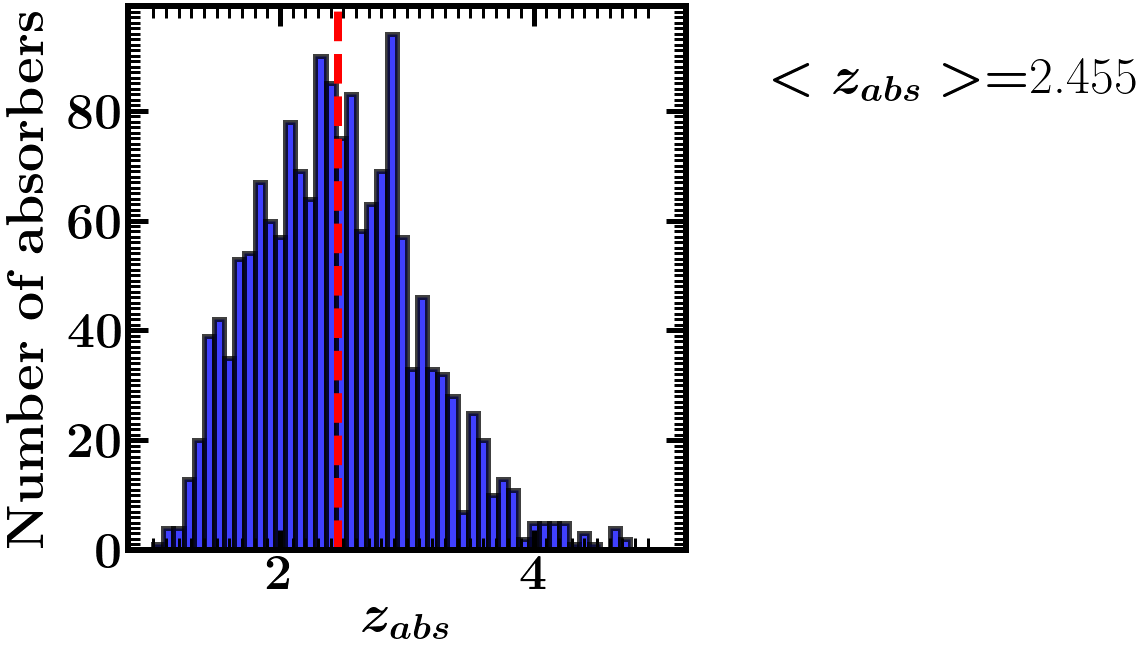

In [8]:
#make histogram of zabs:


fig, ax = plt.subplots(figsize=(10, 10))


#TeX up labels and text:


plt.rc("text", usetex=True)

plt.rc('font', size=32) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)

# weights_z = np.ones_like(Zabs)/float(len(Zabs))
# weights_ew = np.ones_like(np.log10(Ewr))/float(len(Ewr))


plt.hist(Zabs, 50, range=(1,5), facecolor='blue', edgecolor='black', linewidth=5, alpha=0.75)

# logbins_ew = np.logspace(np.log10(min(Ewr)),np.log10(max(Ewr)),len(Ewr))

# ax[1].hist(np.log10(Ewr), bins=50, facecolor='orange',edgecolor='black', linewidth=5, alpha=0.75)



mean_z = str(round(mean_Zabs,4))

# fig.text(0.3, 0.8, r'\boldmath{$<z_{abs}>$}'+'\n'+ r'\boldmath{$=~$}'+mean_z, fontsize=60, weight='bold')

fig.text(1.02, 0.75, r'\boldmath{$<z_{abs}>=$}'+mean_z, fontsize=52)
# fig.text(0.52, 0.75, r'\boldmath{$<\log W_{r}^{1548}>=$}'+mean_ew, fontsize=50)



ax.set_xlabel(r'\boldmath{$z_{abs}$}',fontsize=52)
# ax[1].set_xlabel(r'\boldmath{$\log W_{r}^{1548}$}',fontsize=52,labelpad=30)


# ax[1].tick_params(axis='x', pad=30)

ax.set_ylabel(r'\textbf{Number of absorbers}',fontsize=52, rotation=90,labelpad=15)

ax.axvline(mean_Zabs,ls='--',c='red',lw=8)
# ax[1].axvline(np.log10(mean_Ewr),ls='--',c='red',lw=8)



ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')




# ax[1].set_xscale('log')

ax.set_xticks(np.arange(1,5,0.1), minor=True)
# ax[1].set_xticks(np.arange(-2.4,1,0.1), minor=True)

ax.set_yticks(np.arange(0,100,1), minor=True)
# ax[1].set_yticks(np.arange(0,100,1), minor=True)


# ax[0].set_xlim(8.9,12.2)
# ax[1].set_xlim(8.9,12.2)

# ax[0].set_ylim(1.8,2.65)
# ax[1].set_ylim(1.8,2.65)
# plt.xlim(1.2,4.5)

# ax.legend(loc='best',fontsize=36,framealpha=None)

# fig.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('hist_zabs.pdf', dpi=50)

plt.show()

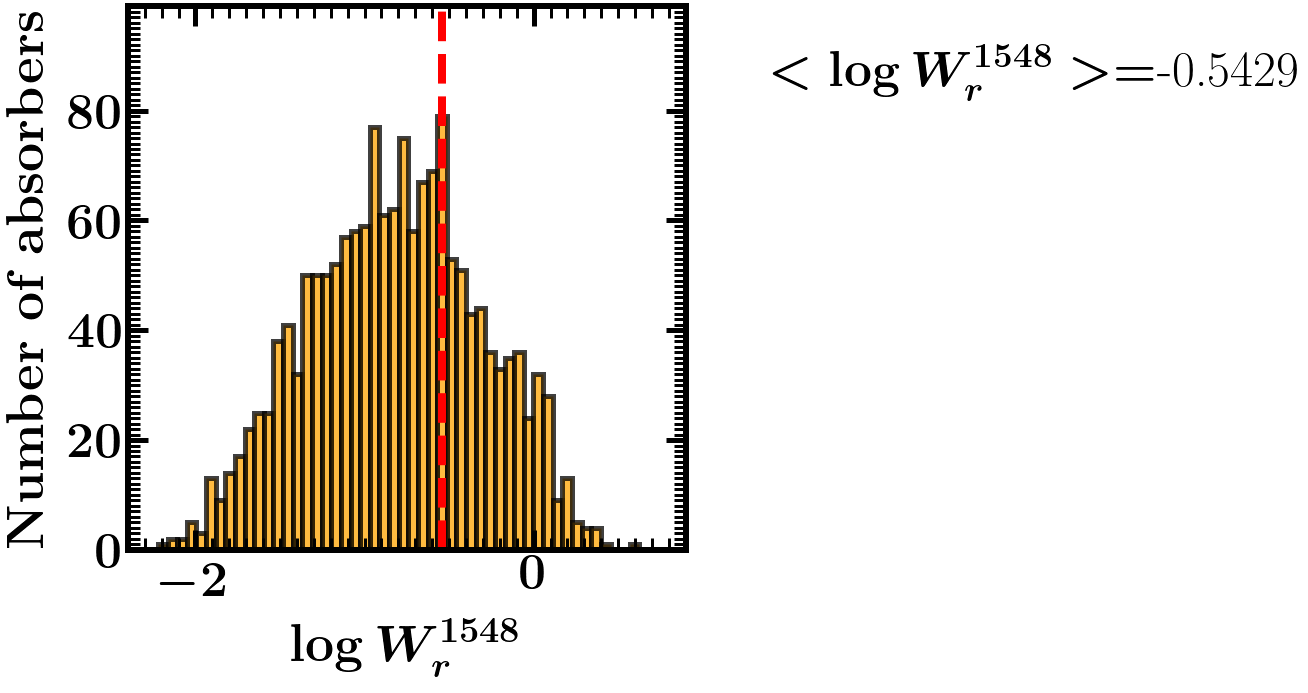

In [10]:
#make histogram of EQW:


fig, ax = plt.subplots(figsize=(10, 10))


#TeX up labels and text:


plt.rc("text", usetex=True)

plt.rc('font', size=32) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)

# weights_z = np.ones_like(Zabs)/float(len(Zabs))
# weights_ew = np.ones_like(np.log10(Ewr))/float(len(Ewr))


plt.hist(np.log10(Ewr), bins=50, facecolor='orange',edgecolor='black', linewidth=5, alpha=0.75)

# logbins_ew = np.logspace(np.log10(min(Ewr)),np.log10(max(Ewr)),len(Ewr))

# ax[1].hist(np.log10(Ewr), bins=50, facecolor='orange',edgecolor='black', linewidth=5, alpha=0.75)


mean_ew = str(round(np.log10(mean_Ewr),4))


# fig.text(0.52, 0.75, r'\boldmath{$<z_{abs}>=$}'+mean_z, fontsize=52)
fig.text(1.02, 0.75, r'\boldmath{$<\log W_{r}^{1548}>=$}'+mean_ew, fontsize=50)


# ax.set_xlabel(r'\boldmath{$z_{abs}$}',fontsize=52)
ax.set_xlabel(r'\boldmath{$\log W_{r}^{1548}$}',fontsize=52,labelpad=30)


# ax[1].tick_params(axis='x', pad=30)

ax.set_ylabel(r'\textbf{Number of absorbers}',fontsize=52, rotation=90,labelpad=15)

# ax.axvline(mean_Zabs,ls='--',c='red',lw=8)
ax.axvline(np.log10(mean_Ewr),ls='--',c='red',lw=8)


ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')




# ax[1].set_xscale('log')

# ax.set_xticks(np.arange(-2.,0.1), minor=True)
ax.set_xticks(np.arange(-2.4,1,0.1), minor=True)

ax.set_yticks(np.arange(0,100,1), minor=True)
# ax[1].set_yticks(np.arange(0,100,1), minor=True)

# ax.legend(loc='best',fontsize=36,framealpha=None)

# fig.tight_layout()

# plt.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('hist_ewr.pdf', dpi=50)

plt.show()

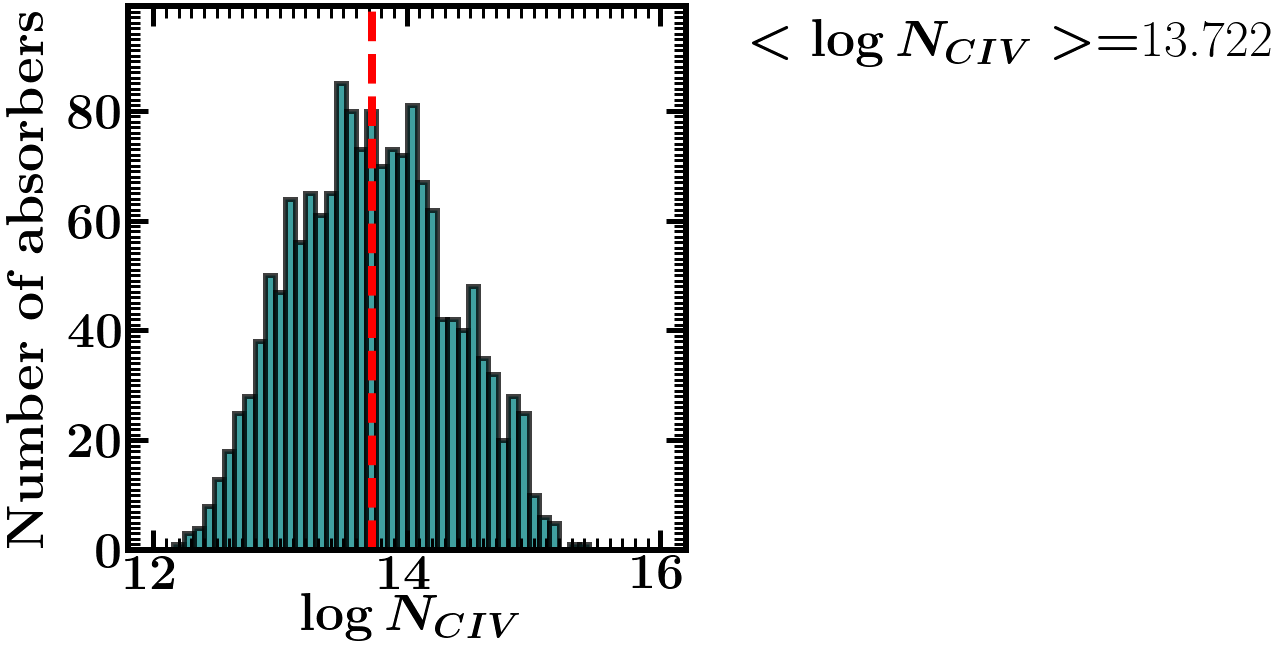

In [11]:
#make histogram of logN:


fig, ax = plt.subplots(figsize=(10, 10))


#TeX up labels and text:


plt.rc("text", usetex=True)

plt.rc('font', size=32) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)

# weights_z = np.ones_like(Zem)/float(len(Zem))



ax.hist(logN, bins=50, range=(12,16), facecolor='teal', edgecolor='black', linewidth=5, alpha=0.75)

# logbins_ew = np.logspace(np.log10(min(Ewr)),np.log10(max(Ewr)),len(Ewr))

# ax[1].hist(np.log10(Ewr), bins=50, weights=weights_ew, facecolor='orange',edgecolor='black', linewidth=5, alpha=0.75)



mean_n = str(round(mean_logN,4))

fig.text(0.99, 0.8, r'\boldmath{$<\log N_{CIV}>=$}'+mean_n, fontsize=52, weight='bold')
# fig.text(0.74, 0.75, r'\boldmath{$<\log W_{r}^{1548}>$}'+'\n'+ r'\boldmath{$=~$}'+mean_ew, fontsize=60)



ax.set_xlabel(r'\boldmath{$\log N_{CIV}$}',fontsize=52)
# ax[1].set_xlabel(r'\boldmath{$\log W_{r}^{1548}$}',fontsize=52,labelpad=30)


# ax[1].tick_params(axis='x', pad=30)

ax.set_ylabel(r'\textbf{Number of absorbers}',fontsize=52, rotation=90,labelpad=15)

ax.axvline(mean_logN,ls='--',c='red',lw=8)
# ax[1].axvline(np.log10(mean_Ewr),ls='--',c='red',lw=8)



ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')



# ax[1].tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
# ax[1].tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')


# ax[1].set_xscale('log')

ax.set_xticks(np.arange(12,16,0.1), minor=True)
# ax[1].set_xticks(np.arange(-2.4,1,0.1), minor=True)

ax.set_yticks(np.arange(0,100,1), minor=True)
# ax[1].set_yticks(np.arange(0,0.07,0.001), minor=True)



# plt.savefig('hist_logN.pdf', dpi=50)

plt.show()

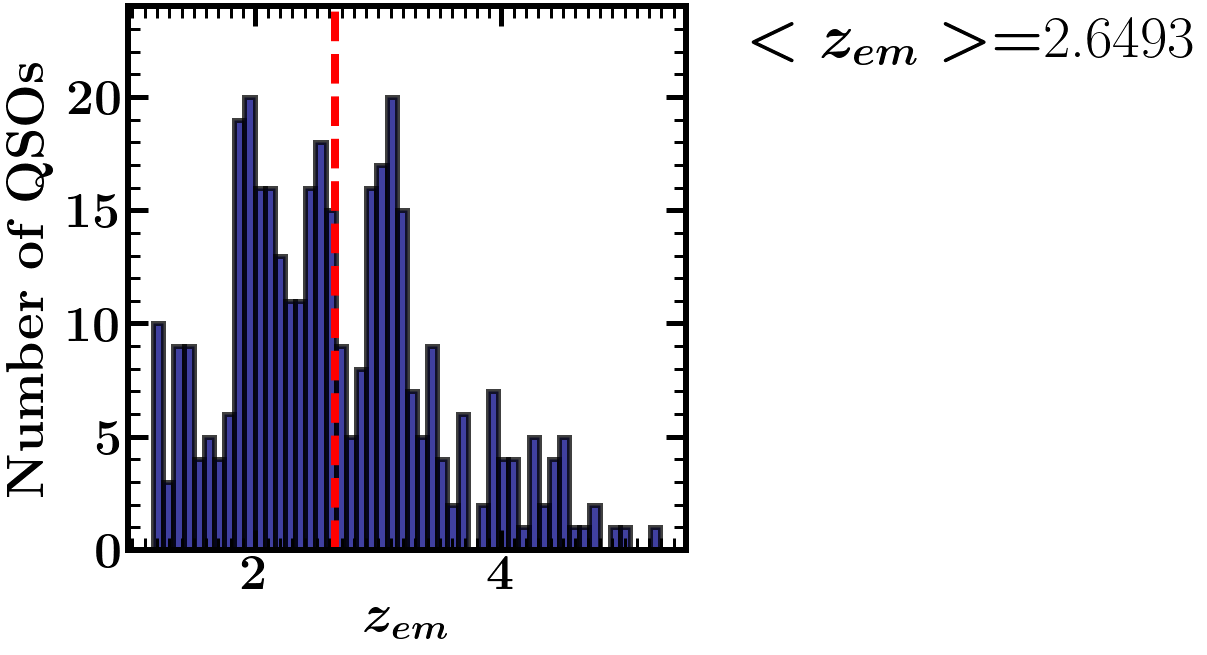

In [12]:
#make histogram of zems:


fig, ax = plt.subplots(figsize=(10,10))


#TeX up labels and text:


plt.rc("text", usetex=True)

plt.rc('font', size=32) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)

# weights_z = np.ones_like(Zem)/float(len(Zem))



plt.hist(Zem, 50, facecolor='navy', edgecolor='black', linewidth=5, alpha=0.75)

# logbins_ew = np.logspace(np.log10(min(Ewr)),np.log10(max(Ewr)),len(Ewr))

# ax[1].hist(np.log10(Ewr), bins=50, weights=weights_ew, facecolor='orange',edgecolor='black', linewidth=5, alpha=0.75)



mean_zem = str(round(mean_Zem,4))

fig.text(0.99, 0.8, r'\boldmath{$<z_{em}>=$}'+mean_zem, fontsize=60, weight='bold')
# fig.text(0.74, 0.75, r'\boldmath{$<\log W_{r}^{1548}>$}'+'\n'+ r'\boldmath{$=~$}'+mean_ew, fontsize=60)



ax.set_xlabel(r'\boldmath{$z_{em}$}',fontsize=52)
# ax[1].set_xlabel(r'\boldmath{$\log W_{r}^{1548}$}',fontsize=52,labelpad=30)


# ax[1].tick_params(axis='x', pad=30)

ax.set_ylabel(r'\textbf{Number of QSOs}',fontsize=52, rotation=90,labelpad=15)

ax.axvline(mean_Zem,ls='--',c='red',lw=8)
# ax[1].axvline(np.log10(mean_Ewr),ls='--',c='red',lw=8)



ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')



# ax[1].tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
# ax[1].tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')


# ax[1].set_xscale('log')

ax.set_xticks(np.arange(1,5.5,0.1), minor=True)
# ax[1].set_xticks(np.arange(-2.4,1,0.1), minor=True)

ax.set_yticks(np.arange(0,25,1), minor=True)
# ax[1].set_yticks(np.arange(0,0.0`7,0.001), minor=True)



# plt.savefig('hist_zem.pdf', dpi=50)

plt.show()

In [8]:
#make lists of absorber info:

absorber_lists = [] #list of lists
absorber_lists_vweak, absorber_lists_vstrong = [], []
absorber_lists_weak, absorber_lists_med, absorber_lists_strong  = [], [], []

for j in range(len(zbins)-1):
     #lists of absorber info for this zbin:
    abslist, abslist_w, abslist_m, abslist_s,  = [],[],[],[]
    abslist_vw, abslist_vs = [],[]
    
    #find all absorbers in this bin:
    for i in range(len(Zabs)):
        zi = Zabs[i]
        wi = Ewr[i]
        wei = Ewsig[i]
        ent = (wi,wei,zi)
        
        if zbins[j] <= zi <= zbins[j+1]:
            abslist.append(ent)

# greater than theresholds:
            if wi >= vweak: #EQW >= 0.01 A
                abslist_vw.append(ent)
            if wi >= weak: #EQW >= 0.3 A
                abslist_w.append(ent)
            if wi >= med: #EQW >= 0.6 A
                abslist_m.append(ent)
            if wi >= strong: #EQW >= 0.9 A
                abslist_s.append(ent)
            if wi >= vstrong: #EQW >= 1.2 A
                abslist_vs.append(ent)
                

##less than thresholds:

#             if wi <= weak: #EQW <= 0.01 A
#                 abslist_w.append(ent)
#             if wi <= med: #EQW <= 0.6 A
#                 abslist_m.append(ent)
#             if wi <= strong: #EQW <= 0.9 A
#                 abslist_s.append(ent)
#             if wi <= vstrong: #EQW <= 1.2 A
#                 abslist_vs.append(ent)

##between thresholds:

#             if vweak <= wi < weak: #EQW between 0.01 A and 0.4 A
#                 abslist_vw.append(ent)
#             if weak <= wi < strong: #EQW between 0.4 A and 1 A
#                 abslist_m.append(ent)
# #             if med <= wi < strong: #EQW between 0.7 A and 1 A
# #                 abslist_m.append(ent)
# #             if strong <= wi < vstrong: #EQW between 0.9 A and 1.2 A
# #                 abslist_s.append(ent)               
#             if wi >= strong: #EQW >= 1 A
#                 abslist_s.append(ent)
                
    absorber_lists.append(abslist)
    absorber_lists_vweak.append(abslist_vw)
    absorber_lists_weak.append(abslist_w)
    absorber_lists_med.append(abslist_m)
    absorber_lists_strong.append(abslist_s)
    absorber_lists_vstrong.append(abslist_vs)


In [761]:
# xx = np.empty(shape=[len(ewbins)])
# xx = np.zeros((len(ewbins),1))
xy = [[] for i in range(len(ewbins)-1)]
# xy = [[None]]*len(ewbins)

# xy[1].append(1)

xy[1].append(2), xy[0].append(14)

xy

[[14], [2], [], [], [], [], [], [], [], [], []]

In [820]:
absorber_lists_ewd[0][0][0], absorber_lists_vweak[0][0]

((0.006, 0.001, 2.248834), (0.112, 0.002, 1.3042216))

In [9]:
#make lists of absorber info for dN/dX between EQW bins:

absorber_lists_ewd = [] #list of lists
# absorber_lists_vweak, absorber_lists_vstrong = [], []
# absorber_lists_weak, absorber_lists_med, absorber_lists_strong  = [], [], []

for j in range(len(zbins_all)-1):
     #lists of absorber info for this zbin:
    abslists = [[] for i in range(len(ewbins)-1)]
#     abslists = []
#     print(len(abslists))
    

    #find all absorbers in this bin:
    for i in range(len(Zabs)):
        zi = Zabs[i]
        wi = Ewr[i]
        wei = Ewsig[i]
        ent = (wi,wei,zi)
        
#         print(ent)

#             if zbins[j] <= zi <= zbins[j+1]:
        for k in range(len(ewbins)-1):
        
#             print(ewbins[k],wi)
#             lst = []
            if ewbins[k] <= wi <= ewbins[k+1]:
#                 print(ewbins[k],wi)
                abslists[k].append(ent)
                
#                 lst.append(ent)
    

#             print(abslists)

    absorber_lists_ewd.append(abslists)

#     absorber_lists.append(abslist)
#     absorber_lists_vweak.append(abslist_vw)
#     absorber_lists_weak.append(abslist_w)
#     absorber_lists_med.append(abslist_m)
#     absorber_lists_strong.append(abslist_s)
#     absorber_lists_vstrong.append(abslist_vs)


In [727]:
ewbins[5],ewbins[6]

(0.11578075137048792, 0.21695198914988656)

In [37]:
len(absorber_lists_ewd[0])

11

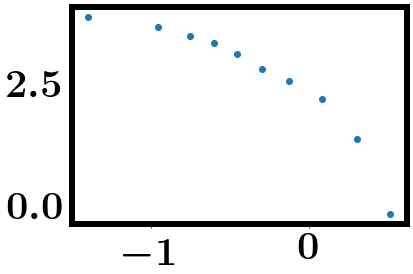

In [117]:
plt.scatter(np.log10(EWD_bins_in), np.log10(EWD_array_in))
# plt.errorbar()
plt.show()

In [10]:
# #make lists of absorber info - for Cooksey+13:

# absorber_lists_c = [] #list of lists
# absorber_lists_c_weak, absorber_lists_c_med, absorber_lists_c_strong  = [], [], []

# for zbin in zbins:
#     abslist, abslist_w, abslist_m, abslist_s = [],[],[],[] #lists of absorber info for this zbin
    
#     #find all absorbers in this bin:
#     for i in range(len(Zabs_c)):
#         zi = Zabs_c[i]
#         wi = Ewr_c[i]
#         wei = Ewsig_c[i]
#         ent = (wi,wei,zi)
        
#         if zbin <= zi <= zbin+dz:
#             abslist.append(ent)
            
#             if wi >= weak: #EQW >= 0.01 A
#                 abslist_w.append(ent)
#             if wi >= med: #EQW >= 0.3 A
#                 abslist_m.append(ent)
#             if wi >= strong: #EQW >= 1 A
#                 abslist_s.append(ent)

                
#     absorber_lists_c.append(abslist)
#     absorber_lists_c_weak.append(abslist_w), absorber_lists_c_med.append(abslist_m), absorber_lists_c_strong.append(abslist_s)


In [104]:
zbins, zbins_c

(array([1.  , 1.5 , 1.8 , 2.  , 2.2 , 2.4 , 2.6 , 2.8 , 3.1 , 3.75, 4.75]),
 array([1.45, 1.61, 1.7 , 1.78, 1.87, 1.96, 2.08, 2.24, 2.51, 2.97, 4.55]))

In [10]:
#define comoving path length:

def dXdz(z,om_m,om_l):
    ''' computes dX/dz for a given redshift and cosmology '''
    num = (1+z)**2
    den = np.sqrt((om_m*(1+z)**3)+om_l)
    return num/den

#define function to compute dN/dz:

def compute_dNdz(abslist,gwzgrid,wgrid,zgrid,zbin_list):

    ''' computes dN/dz for given redshift and EQW of a list of absorbers and a g(W,z) grid...
    ... Inputs: 
    -abslist = list of absorbers, with zabs and EQW
    -gwzgrid = g(W,z) grid
    -wgrid = array of EWlims used in g(W,z) grid
    -zgrid = array of redshifts used in g(W,z) grid
    -zbin_list = list of redshift bins for which dN/dz is computed
    
    ... Outputs:
    -dNdzarray: dN/dz for each redshift bin
    -dNdzerrarray: uncertainty in dN/dz for each redshift bin
    
    '''
    
    dNdzarray, dNdzerrarray = [], [] #make arrays for output

    for i in range(len(zbin_list)-1): #loop over each zbin
        
        zbin1, zbin2 = zbin_list[i], zbin_list[i+1] #redshift limits of this bin
        
        dndz_arr,dndz_arr_e  = [], [] #arrays for this bin
        
        for ab in abslist[i]: #loop over each absorber
            
#             if z1 <= ab[2] <= z2: #if this absorber falls within the redshift bin
            
            id_i = find_nearest(wgrid,ab[0]) #find closest row in g(W,z) grid
            
            id_k = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin
            
#             if i < 9:
#                 id_k = find_nearest(zgrid,zbin_list[i]),find_nearest(zgrid,zbin_list[i+1]) #relevant redshifts for this bin
        
#             else:
#                 id_k = find_nearest(zgrid,zbin_list[i]),find_nearest(zgrid,4.55) #relevant redshifts for this bin

            gwz_row = gwzgrid[id_i][id_k[0]:id_k[1]] #points of interest in the row
    
#             if sum(gwz_row) == 0:
                
#                 print(id_i, id_k, ab[0],sum(gwz_row))
            
            if gwz_row.any() > 0.0: #make sure there is any senstivity in this row
        
                Zsum = sum(gwz_row)*z_spacing

                dndz = 1/Zsum #dN/dz for this absorber = 1/Zsum
            
#             if dndz is not 'inf':
            
                dndz_arr.append(dndz), dndz_arr_e.append(dndz**2)
            
            
        dndz_tot, dndz_e_tot = sum(dndz_arr), np.sqrt(sum(dndz_arr_e)) #sum up contributions from each system
    
        dNdzarray.append(dndz_tot), dNdzerrarray.append(dndz_e_tot) #append 
        

    return dNdzarray, dNdzerrarray #return arrays


In [ ]:
CIV_gwz[0]

In [15]:
w_grid[0], z_grid[240], z_grid[280], CIV_gwz[0][240]

(0.005, 2.1999999999999744, 2.39999999999997, 0.0)

In [11]:
dNdz_array, dNdz_e_array = compute_dNdz(absorber_lists,CIV_gwz,w_grid,z_grid,zbins)  


dNdz_array, dNdz_e_array

([38.54592821683181,
  12.03577066905439,
  15.240487721142221,
  19.47005437245443,
  17.438996678659986,
  37.258391370903546,
  95.80057622653301,
  62.03280126103664,
  22.467303111933216,
  14.894865605654054],
 [20.55988334732741,
  1.475629732757355,
  2.0565426542581164,
  4.348048459458376,
  4.7975680873865185,
  14.3499692522492,
  67.36656746775675,
  40.24825878762301,
  4.352058735739098,
  5.10276811811497])

In [178]:

#define function to compute dN/dX:

def compute_dNdX(abslist,gwzgrid,wgrid,zgrid,zbin_list):

    ''' computes dN/dX for given redshift and EQW of a list of absorbers and a g(W,z) grid...
    ... Inputs: 
    -abslist = list of absorbers, with zabs and EQW
    -gwzgrid = g(W,z) grid
    -wgrid = array of EWlims used in g(W,z) grid
    -zgrid = array of redshifts used in g(W,z) grid
    -zbin_list = list of redshift bins for which dN/dX is computed
    
    ... Outputs:
    -dNdXarray: dN/dX for each redshift bin
    -dNdXerrarray: uncertainty in dN/dX for each redshift bin
    
    '''
    
    dNdXarray, dNdXerrarray = [], [] #make arrays for output

    for i in range(len(zbin_list)-1): #loop over each zbin
        
        zbin1, zbin2 = zbin_list[i], zbin_list[i+1] #redshift limits of this bin
        
        dndx_arr,dndx_arr_e  = [], [] #arrays for this bin
        
        for ab in abslist[i]: #loop over each absorber
            
#             print(ab)
            
            id_i = find_nearest(wgrid,ab[0]) #find closest row in g(W,z) grid
   
            id_k = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin

#             if i < 9:
#                 id_k = find_nearest(zgrid,zbin_list[i]),find_nearest(zgrid,zbin_list[i+1]) #relevant redshifts for this bin
        
#             else:
#                 id_k = find_nearest(zgrid,zbin_list[i]),find_nearest(zgrid,4.55) #relevant redshifts for this bin
            
            gwz_row = gwzgrid[id_i][id_k[0]:id_k[1]] #points of interest in the row
            
            if gwz_row.any() > 0.0:  #make sure there is any senstivity in this row
                
                dxdz = dXdz(ab[2],omega_m,omega_l)
                Xsum = sum(gwz_row*dxdz)*z_spacing

                dndx = 1/Xsum #dN/dX for this absorber = 1/Zsum

                dndx_arr.append(dndx), dndx_arr_e.append(dndx**2)
            
            
        dndx_tot, dndx_e_tot = sum(dndx_arr), np.sqrt(sum(dndx_arr_e)) #sum up contributions from each system
    
        dNdXarray.append(dndx_tot), dNdXerrarray.append(dndx_e_tot) #append 
        

    return dNdXarray, dNdXerrarray #return arrays


In [13]:
help(compute_dNdX)

Help on function compute_dNdX in module __main__:

compute_dNdX(abslist, gwzgrid, wgrid, zgrid, zbin_list)
    computes dN/dX for given redshift and EQW of a list of absorbers and a g(W,z) grid...
    ... Inputs: 
    -abslist = list of absorbers, with zabs and EQW
    -gwzgrid = g(W,z) grid
    -wgrid = array of EWlims used in g(W,z) grid
    -zgrid = array of redshifts used in g(W,z) grid
    -zbin_list = list of redshift bins for which dN/dX is computed
    
    ... Outputs:
    -dNdXarray: dN/dX for each redshift bin
    -dNdXerrarray: uncertainty in dN/dX for each redshift bin



In [13]:

# #define function to compute dN/dX:

# def compute_dNdX_2(abslist,gwzgrid,wgrid,zgrid,zbin_list):

#     ''' computes dN/dX for given redshift and EQW of a list of absorbers and a g(W,z) grid...
#     ... Inputs: 
#     -abslist = list of absorbers, with zabs and EQW
#     -gwzgrid = g(W,z) grid
#     -wgrid = array of EWlims used in g(W,z) grid
#     -zgrid = array of redshifts used in g(W,z) grid
#     -zbin_list = list of redshift bins for which dN/dX is computed
    
#     ... Outputs:
#     -dNdXarray: dN/dX for each redshift bin
#     -dNdXerrarray: uncertainty in dN/dX for each redshift bin
    
#     '''
    
#     dNdXarray, dNdXerrarray = [], [] #make arrays for output

#     for i in range(len(zbin_list)-1): #loop over each zbin
        
#         zbin1, zbin2 = zbin_list[i], zbin_list[i+1] #redshift limits of this bin
        
#         dndx_arr,dndx_arr_e  = [], [] #arrays for this bin
        
#         for ab in abslist: #loop over each absorber
            
# #             print(ab)
            
#             id_i = find_nearest(wgrid,ab[0]) #find closest row in g(W,z) grid
   
#             id_k = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin

# #             if i < 9:
# #                 id_k = find_nearest(zgrid,zbin_list[i]),find_nearest(zgrid,zbin_list[i+1]) #relevant redshifts for this bin
        
# #             else:
# #                 id_k = find_nearest(zgrid,zbin_list[i]),find_nearest(zgrid,4.55) #relevant redshifts for this bin
            
#             gwz_row = gwzgrid[id_i][id_k[0]:id_k[1]] #points of interest in the row
            
#             if gwz_row.any() > 0.0:  #make sure there is any senstivity in this row
                
#                 dxdz = dXdz(ab[2],omega_m,omega_l)
#                 Zsum = sum(gwz_row*dxdz)*z_spacing

#                 dndx = 1/Zsum #dN/dX for this absorber = 1/Zsum

#                 dndx_arr.append(dndx), dndx_arr_e.append(dndx**2)
            
            
#         dndx_tot, dndx_e_tot = sum(dndx_arr), np.sqrt(sum(dndx_arr_e)) #sum up contributions from each system
    
#         dNdXarray.append(dndx_tot), dNdXerrarray.append(dndx_e_tot) #append 
        

#     return dNdXarray, dNdXerrarray #return arrays


In [608]:
len(ewbins)

12

In [ ]:
dNdz_array, dNdz_e_array = compute_dNdz(absorber_lists,CIV_gwz,w_grid,z_grid,zbins)  

dNdz_array, dNdz_e_array

# for ab in absorber_lists[0]:
#     print(ab[0])
    
# len(absorber_lists)

In [172]:
    
# def compute_dX(abslist,gwzgrid,wgrid,zgrid,zbin_list,ewbin_list):
    
#     ''' computes a redshift path for a given EQW bin
    
#    ... Inputs: 
   
#     -abslist = list of absorbers, with zabs and EQW
#     -gwzgrid = g(W,z) grid
#     -wgrid = array of EWlims used in g(W,z) grid
#     -zgrid = array of redshifts used in g(W,z) grid
#     -zbin_list = list of redshift bins for which dN/dX is computed
    
#     ... Outputs:
#     -dXarray: dX array for each EQW bin

    
#     '''
    
#     dXarray = [] #make arrays for output

#     for i in range(len(zbin_list)-1): #loop over each zbin
        
#         zbin1, zbin2 = zbin_list[i], zbin_list[i+1] #redshift limits of this bin
        
#         dx_arr_z  = [] #arrays for this z-bin
        
#         gzs = 0
    
#         for m in range(len(gwzgrid)): #loop thru each row in the gwz grid
            
#             delz_cov = gwzgrid[m][zbin1:zbin2]
#             dxdz = dXdz(np.mean([zbin1,zbin2]),omega_m,omega_l)

#             gzs += sum(delz_cov*dxdz) 
            
#         gzsum = gzs * z_spacing
        
#         print(gzsum)
        
#         arr_all = []
        
#         for j in range(len(ewbin_list)-1):
            
#             ewbin1, ewbin2 = ewbin_list[j], ewbin_list[j+1]
            
#             dx_arr_w = [] #arrays for this EQW-bin
            
# #             id_i = find_nearest(wgrid,ewbin1) #find closest row in g(W,z) grid

# #             id_k = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin

# #             gwz_row = gwzgrid[id_i][id_k[0]:id_k[1]] #points of interest in the row

# #             if gwz_row.any() > 0.0:  #make sure there is any senstivity in this row

# #                 dxdz = dXdz(zabs,omega_m,omega_l)
# #                 Zsum = sum(gwz_row*dxdz)*z_spacing

#             id_k = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin

#             w_c = np.mean([ewbin1, ewbin2])
                       
#             w1 = find_nearest(wgrid,w_c) #find closest row in g(W,z) grid to the EQW bin center

#             delwz = gwzgrid[w1][id_k[0]:id_k[1]] #g(W,z)

#             if delwz.any() > 0.0:
        
#                 gwzsum = sum(delwz)*z_spacing
            
# #                 print(gwzsum)
            
        
#             for k in range(len(abslist[j])): #loop over each absorber
    
#                 wr, zabs = abslist[j][k][0], abslist[j][k][2]   #W_r, zabs

#                 id_i = find_nearest(wgrid,wr) #find closest row in g(W,z) grid


#                 gwz_row = gwzgrid[id_i][id_k[0]:id_k[1]] #points of interest in the row
                               

#                 if gwz_row.any() > 0.0:  #make sure there is any senstivity in this row

#                     dxdz = dXdz(zabs,omega_m,omega_l)
#     #                     Zsum = sum(gwz_row*dxdz)*z_spacing

#                     Xsum = sum(gwz_row*dxdz)*z_spacing
        
#                     Xsum_all = gzs*dxdz*z_spacing

#                     dx_arr_w.append(Xsum)
#                     arr_all.append(Xsum_all)

            
#             dx_w = sum(dx_arr_w)  #sum up contributions from each system - for this EQW-bin
#             dx_arr_z.append(dx_w)
            
#         dx_all = sum(arr_all)
            
#         dXarray.append(dx_arr_z/dx_all) #append 
        

#     return dXarray #return arrays
        

In [175]:
#define a function to calculate redshift path completeness:


def compute_fz(distarray,gwzgrid,wgrid,zgrid,zbin_list):
    
    ''' computes a redshift path completeness for a given EQW or column density bin
    
    ... Inputs: 
    
    -distarray = bins for which to compute fz
    -gwzgrid = g(W,z) grid
    -wgrid = array of EWlims used in g(W,z) grid
    -zgrid = array of redshifts used in g(W,z) grid
    -zbin_list = list of redshift bins for which fz is computed
    
    ... Outputs:
    
    -fz_array = array of fz values for each distarray bin

    '''
    
    fz_array = []
    
    for i in range(len(zbin_list)-1): #loop over each zbin
        
        zbin1, zbin2 = zbin_list[i], zbin_list[i+1] #redshift limits of this bin
                
        fz_arr = [] #arrays for this bin
        
        z1, z2 = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin
        
#         print(z1, z2)
#         delz_cov = [m for m in gwzgrid[j][id_k[0]:id_k[1]]] #total redshift path covered in this bin

        gzs = 0
    
        for m in range(len(gwzgrid)): #loop thru each row in the gwz grid
            
            delz_cov = gwzgrid[m][z1:z2]
#             print(delz_cov)
            gzs += sum(delz_cov)
            
        gzsum = gzs * z_spacing
#         print(gzsum)        

        for i in range(len(distarray)-1):
            
            w_c = np.mean([distarray[i],distarray[i+1]])
            
            w1 = find_nearest(wgrid,w_c) #find closest row in g(W,z) grid to the EQW bin center

#             print(w1)
            delwz = gwzgrid[w1][z1:z2] #g(W,z)
#             print(delwz)
            if delwz.any() > 0.0:
        
                gwzsum = sum(delwz)*z_spacing
            
#                 print(gwzsum)
                fz = gwzsum/gzsum #fraction of covered redshift path
#                 print(fz)
                fz_arr.append(fz)
#                 print(fz_arr)
        fz_array.append(fz_arr)
#                 np.append(fz_array,fz)
        
    
    return fz_array
        

In [319]:
    
def compute_fX(distarray,gwzgrid,wgrid,zgrid,zbin_list,abslist):
    
    ''' computes a redshift path completeness for a given EQW or column density bin
    
    ... Inputs: 
    
    -distarray = (EQW) bins for which to compute fz
    -gwzgrid = g(W,z) grid
    -wgrid = array of EWlims used in g(W,z) grid
    -zgrid = array of redshifts used in g(W,z) grid
    -zbin_list = list of redshift bins for which fz is computed
    -abslist = list of absorbers
    
    ... Outputs:
    
    -fX_array = array of fX values for each distarray bin

    '''
    
    fX_arr = []
    
    for i in range(len(zbin_list)-1): #loop over each zbin
        
        zbin1, zbin2 = zbin_list[i], zbin_list[i+1] #redshift limits of this bin
        
        z_c = np.mean([distarray[i],distarray[i+1]]) #mean redshift of this bin
        
        dx_arr  = [] #arrays for this bin
        
        sm_w = 0
        
        #loop over each absorber:
        
        for ab in abslist: 
            
            for l in range(len(ab)):
                
                wabs,zabs = ab[l][0], ab[l][2]

                id_i = find_nearest(wgrid,wabs) #find closest row in g(W,z) grid

                id_k = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin

                gwz_row = gwzgrid[id_i][id_k[0]:id_k[1]] #points of interest in the row

                if gwz_row.any() > 0.0:  #make sure there is any senstivity in this row

                    dxdz = dXdz(zabs,omega_m,omega_l)
                    Xsum = sum(gwz_row*dxdz)*z_spacing

                    dx_arr.append(Xsum)
            
        sum_dx_tot = sum(dx_arr) #total redshift path from ALL absorbers
        
#         dX_arr.append(sum_dx)
#         dndx_tot, dndx_e_tot = sum(dndx_arr), np.sqrt(sum(dndx_arr_e)) #sum up contributions from each system
    
#         dNdXarray.append(dndx_tot), dNdXerrarray.append(dndx_e_tot) #append 

        for j in range(len(distarray)-1): #loop over EQW bin
            
            dx_arr_w = []
            
            wbin1, wbin2 = distarray[j], distarray[j+1] #EQW limits of this bin

            w_c = np.mean([distarray[j],distarray[j+1]])
            
            w1 = find_nearest(wgrid,w_c) #find closest row in g(W,z) grid to the EQW bin center

#             for ab in abslist: 

#             for l in range(len(abslist[j])):

#                 wabs,zabs = abslist[j][l][0], abslist[j][l][2]

#                 if wbin1 <= wabs <= wbin2:
                    
#                     print(abslist[j])

#             id_i = find_nearest(wgrid,w1) #find closest row in g(W,z) grid

            z01,z02 = find_nearest(zgrid,zbin1),find_nearest(zgrid,zbin2) #relevant redshifts for this bin

            gwz_row = gwzgrid[w1][z01:z02] #points of interest in the row

            if gwz_row.any() > 0.0:

                dxdz = dXdz(zbin1,omega_m,omega_l)
                Xsum = sum(gwz_row*dxdz)*z_spacing

                dx_arr_w.append(Xsum)

            sum_dx_w = sum(dx_arr_w)      
            
            sm_w += sum_dx_w

#             print(sum_dx_w,sum_dx_tot)
            
            fX_bin = (sum_dx_w/sum_dx_tot)#fX for this EQW bin
            
            fX_arr.append(fX_bin)
            
    return fX_arr, sum_dx_w

In [323]:
compute_fX(ewbins,CIV_gwz,w_grid,z_grid,zbins_all,absorber_lists_ewd[0])
# compute_dX(absorber_lists_ewd[0],CIV_gwz,w_grid,z_grid,zbins_all,ewbins_all)[0]
# compute_fz(ewbins,CIV_gwz,w_grid,z_grid,zbins_all)

([1.4667980305157778e-07,
  2.5033353054136042e-05,
  9.873995408755422e-05,
  0.0002392225354602041,
  0.00042060433525040175,
  0.0005149683418802492,
  0.0005551463845994606,
  0.0005647172417485763,
  0.0005647172417485763,
  0.0005647172417485763,
  0.0005647172417485763],
 524.7967348442896)

In [ ]:
# for ls in absorber_lists_ewd[0]:
#     for l in range(len(ls)):
#         print(ls[l][0])

for j in range(len(ewbins)-1):
    for l in range(len(absorber_lists_ewd[0][j])):
        wabs,zabs = absorber_lists_ewd[0][j][l][0], absorber_lists_ewd[0][j][l][2]
        
        print(wabs,zabs)


In [ ]:
# for j in range(len(ewbins)-1):
    
#     for k in range(len(absorber_lists_ewd[0][j])):
        
#         print(absorber_lists_ewd[0][j][k][2])
        
        

In [220]:
len(absorber_lists_ewd[0]), len(ewbins)

(11, 12)

In [340]:
#compute redshift paths:

# fX_arrays_ew = compute_fX(ewbins,CIV_gwz,w_grid,z_grid,zbins_all,absorber_lists_ewd[0])

#compute fX:

#all redshifts:
norm_fX = compute_fX(ewbins,CIV_gwz,w_grid,z_grid,zbins_all,absorber_lists_ewd[0])[1]


fX_unscaled_ew = compute_fX(ewbins,CIV_gwz,w_grid,z_grid,zbins_all,absorber_lists_ewd[0])[0]
fX_scaled_ew = []

# for arr in fX_unscaled_ew:
#     for i in range(len(arr)):
#         scaled = arr[i]/max(arr)
#         fX_scaled_ew.append(scaled)

for i in range(len(fX_unscaled_ew)):
    scaled = (fX_unscaled_ew[i]/max(fX_unscaled_ew))
    fX_scaled_ew.append(scaled)

#by z-bins:
# fz_unscaled_ew_bins = compute_fz(ewbins,CIV_gwz,w_grid,z_grid,zbins_large) 

# fz_scaled_ew_bins = []

# for arr in fz_unscaled_ew_bins:
#     fz0 = []
#     for i in range(len(arr)):
#         scaled = arr[i]/max(arr)
#         fz0.append(scaled)
#     fz_scaled_ew_bins.append(fz0)
# fz_scaled_ew_bins = [i/max(fz_unscaled_ew_bins) for i in fz_unscaled_ew_bins]




([1.4667980305157778e-07,
  2.5033353054136042e-05,
  9.873995408755422e-05,
  0.0002392225354602041,
  0.00042060433525040175,
  0.0005149683418802492,
  0.0005551463845994606,
  0.0005647172417485763,
  0.0005647172417485763,
  0.0005647172417485763,
  0.0005647172417485763],
 [0.00025974025974025887,
  0.044329004329004364,
  0.17484848484848506,
  0.4236147186147202,
  0.7448051948051967,
  0.9119047619047618,
  0.9830519480519477,
  1.0,
  1.0,
  1.0,
  1.0])

In [344]:
dXarrays_EQW[0], dXarrays_EQW_scaled
fX_unscaled_ew,fX_scaled_ew

([1.4667980305157778e-07,
  2.5033353054136042e-05,
  9.873995408755422e-05,
  0.0002392225354602041,
  0.00042060433525040175,
  0.0005149683418802492,
  0.0005551463845994606,
  0.0005647172417485763,
  0.0005647172417485763,
  0.0005647172417485763,
  0.0005647172417485763],
 [0.00025974025974025887,
  0.044329004329004364,
  0.17484848484848506,
  0.4236147186147202,
  0.7448051948051967,
  0.9119047619047618,
  0.9830519480519477,
  1.0,
  1.0,
  1.0,
  1.0])

In [253]:
#make initial EQW distributions:


absorber_lists_ew = [] #list of lists
absorber_lists_ew_low = []
absorber_lists_ew_mid = []
absorber_lists_ew_high = []

for j in range(len(ewbins)-1):
    #lists of absorber info for this ewbin:
    abslist = [] 
    abslist_l, abslist_m, abslist_h = [],[],[]
    
    #find all absorbers in this bin:
    for i in range(len(Ewr)):
        zi = Zabs[i]
        wi = Ewr[i]
        wei = Ewsig[i]
        ent = (wi,wei,zi)
        
        if ewbins[j] <= wi < ewbins[j+1]:
            abslist.append(ent)
        
            if zbins_large[0] <= zi < zbins_large[1]:
                abslist_l.append(ent)
                
            if zbins_large[1] <= zi < zbins_large[2]:
                abslist_m.append(ent)
                
            if zi >= zbins_large[2]:
                abslist_h.append(ent)

                
    absorber_lists_ew.append(abslist)
    absorber_lists_ew_low.append(abslist_l),absorber_lists_ew_mid.append(abslist_m),absorber_lists_ew_high.append(abslist_h)


EWD_bins_in = [] #initial EQW bins
EWD_array_in, EWD_array_e_in = [], [] #initial EWD array and error arrays
EWD_array_in_l, EWD_array_e_in_l = [], [] #for 1 <= z < 2
EWD_array_in_m, EWD_array_e_in_m = [], [] #for 2 <= z < 3
EWD_array_in_h, EWD_array_e_in_h = [], [] #for z >= 3

EWD_bin_width = []

for i in range(len(ewbins)-1):
    
    del_w = ewbins[i+1]-ewbins[i]
    bin_c = 0.5*(ewbins[i+1]+ewbins[i])
#     print(num)
#     print(del_w)
    num = len(absorber_lists_ew[i])
#     print(num)
    ewd = num/del_w
    ewd_e = np.sqrt(num)/del_w
    
    num_l = len(absorber_lists_ew_low[i])
    ewd_l = num_l/del_w
    ewd_e_l = np.sqrt(num_l)/del_w
    
    num_m = len(absorber_lists_ew_mid[i])
    ewd_m = num_m/del_w
    ewd_e_m = np.sqrt(num_m)/del_w
    
    num_h = len(absorber_lists_ew_high[i])
    ewd_h = num_h/del_w
    ewd_e_h = np.sqrt(num_h)/del_w
    
#     ewd_log = np.log10(ewd)
#     ewd_e_log = 0.434*(ewd_e/ewd)
    EWD_bin_width.append(del_w)
    EWD_bins_in.append(bin_c)
    EWD_array_in.append(ewd), EWD_array_e_in.append(ewd_e)
    EWD_array_in_l.append(ewd_l), EWD_array_e_in_l.append(ewd_e_l)
    EWD_array_in_m.append(ewd_m), EWD_array_e_in_m.append(ewd_e_m)
    EWD_array_in_h.append(ewd_h), EWD_array_e_in_h.append(ewd_e_h)

    

In [254]:
EWD_array_in_l, EWD_array_e_in_l, EWD_array_in_m, EWD_array_e_in_m, EWD_array_in_h, EWD_array_e_in_h

([0.0,
  365.57230093307453,
  1820.8861228505377,
  1249.3956306768048,
  1037.1897980430663,
  731.4331782848714,
  443.0930620803507,
  174.5340155154019,
  88.63660844968287,
  12.827848682580518,
  0.4278648137647398],
 [0.0,
  211.06326635198144,
  344.11513191650926,
  208.2326051128008,
  138.60031676194328,
  85.02737987450328,
  48.345416592689865,
  22.16584213630926,
  11.539503527097903,
  3.2069621706451295,
  0.4278648137647398],
 [685.0157468035557,
  3777.5804429751033,
  4877.373543349655,
  4650.5281808525515,
  2981.9206693738156,
  1779.1617850172547,
  891.4610415664199,
  247.7256994412156,
  88.63660844968287,
  11.224367597257954,
  0.4278648137647398],
 [395.49402581616533,
  678.4734763909815,
  563.1905856382565,
  401.74444577148404,
  235.0082710112969,
  132.6108898089483,
  68.57392627434,
  26.407648290280903,
  11.539503527097903,
  2.9998384237247357,
  0.4278648137647398],
 [685.0157468035557,
  1096.7169027992236,
  1560.7595338718895,
  1561.744538

In [343]:
#compute normalized + completeness-corrected EWD:

EWD_array = [(a/b)/norm_fX for a,b in zip(EWD_array_in,fX_scaled_ew)]

EWD_array_e = [(a/b)/norm_fX for a,b in zip(EWD_array_e_in,fX_scaled_ew)]


# EWD_array_f = [i/dX_tot[0] for i in EWD_array]

EWD_array_in,dXarrays_EQW_scaled

EWD_array, EWD_array_e

([10050.789001102317,
  225.23785461070003,
  90.00683245394526,
  33.564004935540325,
  13.362431634878053,
  6.402712814818499,
  3.0776169629853904,
  0.9709029970727583,
  0.366420669387251,
  0.045831489951961894,
  0.0016305925146111661],
 [4103.217427513019,
  34.34845081291482,
  7.986814866993386,
  2.2890461375997537,
  0.7957212242081285,
  0.3636496514461503,
  0.17739089268287883,
  0.07216665142980108,
  0.0323873175113299,
  0.008367646963586965,
  0.00115300302443358])

In [143]:
EWD_array_in, dXarrays_EQW[0], EWD_array

([1370.0314936071113,
  5239.869646707401,
  8259.019200072082,
  7461.668349875362,
  5222.991483002585,
  3064.111963085272,
  1587.7501391212568,
  509.52672271431845,
  192.29637087388826,
  24.052216279838472,
  0.8557296275294796],
 [23.18014256440293,
  1204.683364460273,
  17402.123827061492,
  73155.84010747155,
  157531.62392648778,
  212075.24568554142,
  220238.16868626623,
  134589.7787879791,
  90869.61264094512,
  20813.850064003087,
  1404.750452035296],
 [59.10366986745926,
  4.34958247228307,
  0.47459834685400537,
  0.10199689237268819,
  0.0331551935593573,
  0.014448230170288906,
  0.007209241470687305,
  0.003785775764718226,
  0.0021161790535380916,
  0.0011555870829220605,
  0.000609168430086384])

In [152]:
#compute fz:

#all redshifts:
fz_unscaled_ew = compute_fz(ewbins,CIV_gwz,w_grid,z_grid,zbins_all) 

fz_scaled_ew = []

for arr in fz_unscaled_ew:
    for i in range(len(arr)):
        scaled = arr[i]/max(arr)
        fz_scaled_ew.append(scaled)

# fz_scaled_ew = [i/max(fz_unscaled_ew) for i in fz_unscaled_ew]

#by z-bins:
# fz_unscaled_ew_bins = compute_fz(ewbins,CIV_gwz,w_grid,z_grid,zbins_large) 

# fz_scaled_ew_bins = []

# for arr in fz_unscaled_ew_bins:
#     fz0 = []
#     for i in range(len(arr)):
#         scaled = arr[i]/max(arr)
#         fz0.append(scaled)
#     fz_scaled_ew_bins.append(fz0)
# fz_scaled_ew_bins = [i/max(fz_unscaled_ew_bins) for i in fz_unscaled_ew_bins]



In [153]:
fz_unscaled_ew

[[3.952431173351655e-06,
  0.0006745482535853491,
  0.0026606449181945557,
  0.006446085874472103,
  0.011333596389585872,
  0.013876327111108769,
  0.014958963883342676,
  0.01521686001740387,
  0.01521686001740387,
  0.01521686001740387,
  0.01521686001740387]]

In [40]:
#Complete EWD:

EWD_array = [a/b for a,b in zip(EWD_array_in,fz_scaled_ew)]
EWD_array_e = [a/b for a,b in zip(EWD_array_e_in,fz_scaled_ew)]


EWD_array_f = [a/b for a,b in zip(EWD_array,dXarrays_EQW[0])]
EWD_array_e_f = [a/b for a,b in zip(EWD_array_e,dXarrays_EQW[0])]


EWD_array_l = [a/b for a,b in zip(EWD_array_in_l,fz_scaled_ew_bins[0])]
EWD_array_e_l = [a/b for a,b in zip(EWD_array_e_in_l,fz_scaled_ew_bins[0])]

EWD_array_m = [a/b for a,b in zip(EWD_array_in_m,fz_scaled_ew_bins[1])]
EWD_array_e_m = [a/b for a,b in zip(EWD_array_e_in_m,fz_scaled_ew_bins[1])]

EWD_array_h = [a/b for a,b in zip(EWD_array_in_h,fz_scaled_ew_bins[2])]
EWD_array_e_h = [a/b for a,b in zip(EWD_array_e_in_h,fz_scaled_ew_bins[2])]


In [41]:
EWD_array_in, EWD_array, EWD_array_f, fz_scaled_ew, dXarrays_EQW[0]

([1370.0314936071113,
  5239.869646707401,
  8259.019200072082,
  7461.668349875362,
  5222.991483002585,
  3064.111963085272,
  1587.7501391212568,
  509.52672271431845,
  192.29637087388826,
  24.052216279838472,
  0.8557296275294796],
 [5274621.250387379,
  118204.0906630283,
  47235.29178550757,
  17614.280198469252,
  7012.5604915640615,
  3360.122779362439,
  1615.1233332761315,
  509.52672271431845,
  192.29637087388826,
  24.052216279838472,
  0.8557296275294796],
 [13652.94773938309,
  1004.7535510973893,
  109.63221812327525,
  23.561282138090974,
  7.658849712211536,
  3.3375411693367374,
  1.6653347797287674,
  0.8745142016499102,
  0.48883736136729916,
  0.266940616154996,
  0.1407179073499547],
 [0.00025974025974025974,
  0.04432900432900433,
  0.17484848484848486,
  0.4236147186147186,
  0.7448051948051949,
  0.911904761904762,
  0.9830519480519481,
  1.0,
  1.0,
  1.0,
  1.0],
 [386.3357094067155,
  117.64485981057354,
  430.8522858891184,
  747.5942987836243,
  915.615

In [24]:
# #Normalizing to dN/dX:

# # dNdX_norm, dNdX_norm_e = [], []

# # for lst in absorber_lists_ewd[0]:
# # #     lst = absorber_lists_ewd[0][i]
# # #     print(lst[0])

# # #     for i in range(len(lst)):
# # #         print(lst[i][0])
# #     dndx, dndx_e = compute_dNdX_2(lst,CIV_gwz,w_grid,z_grid,zbins_all)  
# # #     print(dndx, dndx_e)

# # #     print(nnn)
# # #     dNdX_norm.append(dndx)
# # #     dNdX_norm.append(nnn), dNdX_norm_e(nnn)
# #     for j in range(len(dndx)):
# # #         print(val)
# #         dNdX_norm.append(dndx[j])
# #         dNdX_norm_e.append(dndx_e[j])

# #calculate global dN/dX:

# dNdX_norm, dNdX_norm_e = compute_dNdX(absorber_lists,CIV_gwz,w_grid,z_grid,zbins_all) 
    
# big_sigma = sum([a*b for a,b in zip(EWD_array,EWD_bin_width)]) #f_cor * bin_width summed

# norm_const = dNdX_norm/big_sigma

# norm_const

# # dNdX_norm, dNdX_norm_e

# # dNdz_array_vweak, dNdz_e_array_vweak = compute_dNdz(absorber_lists_vweak,CIV_gwz,w_grid,z_grid,zbins)


array([9.72957829e-06])

In [ ]:
# #EWD normalized to dN/dX:

# # dNdX_norm, dNdX_norm_e = compute_dNdX_W(absorber_lists_ew,CIV_gwz,w_grid,z_grid,zbins_large,ewbins)  
# EWD_norm = [a*norm_const for a in EWD_array]
# EWD_norm_e = [a*norm_const for a in EWD_array_e]

# # dNdX_norm, dNdX_norm_e


# # EWD_norm,EWD_norm_e

# EWD_norm, EWD_norm_e


In [898]:
# plt.plot(EWD_array,EWD_norm)
# plt.show()

In [26]:
#make initial CD distribution:


absorber_lists_cd, absorber_lists_cd_l, absorber_lists_cd_u  = [],[],[] #list of lists
# absorber_lists_vweak_ew, absorber_lists_vstrong = [], []
# absorber_lists_weak_ew, absorber_lists_med_ew, absorber_lists_strong_ew  = [], [], []

for j in range(len(columnbins)-1):
    #lists of absorber info for this ewbin:
    abslist,abslist_l,abslist_u  = [],[],[]  
#     abslist_vw, abslist_vs = [],[]
    
    #find all absorbers in this bin:
    for i in range(len(N_abs)):
        zi = Zabs[i]
#         wi = Ewr[i]
#         wei = Ewsig[i]
        col = N_abs[i]
        col_l, col_u = N_abs_l, N_abs_u
        ent = (col,col_l, col_u, zi)
        
        if columnbins[j] <= col < columnbins[j+1]:
            abslist.append(ent)
        
#         if columnbins[j]-N_abs_l[j] <= col < columnbins[j+1]-+N_abs_l[j+1]:
#             abslist_l.append(ent)
            
#         if columnbins[j]+N_abs_u[j] <= col < columnbins[j+1]-+N_abs_u[j+1]:
#             abslist_u.append(ent)
                
    absorber_lists_cd.append(abslist)



CDD_bins_in = [] #initial CD bins
CDD_array_in, CDD_array_l_in, CDD_array_u_in = [], [], [] #initial CDD array and error arrays
CDD_array_e_in = []

for i in range(len(columnbins)-1):
    
    del_n = columnbins[i+1]-columnbins[i]
    bin_c = 0.5*(columnbins[i+1]+columnbins[i])
#     print(del_w)
    num = len(absorber_lists_cd[i])
#     print(num)
    cdd = (num/del_n)
    cdd_e = np.sqrt(num)/del_n
#     cdd_l = num
    cdd_log = np.log10(cdd)
    cdd_e_log = 0.434*(cdd_e/cdd)
    
    CDD_bins_in.append(bin_c)
    CDD_array_in.append(cdd), CDD_array_e_in.append(cdd_e)
#     CDD_array_l_in.append(cdd_l), CDD_array_u_in.append(cdd_u)

# EWD_bins_in, EWD_array_in, EWD_array_e_in

CDD_array_in, CDD_array_e_in

    

([3.7017584357564544e-12,
  1.8236862427939668e-11,
  3.014418592003461e-11,
  2.3325367023324137e-11,
  1.4124947549722342e-11,
  6.978889514987146e-12,
  3.2630460846730417e-12,
  9.43200023827684e-13,
  3.0837516843858663e-13,
  6.840777730280677e-14,
  1.2177549322702999e-15],
 [1.8508792178782272e-12,
  2.848119410416316e-12,
  2.5385984081543465e-12,
  1.5481589845005475e-12,
  8.35225657884644e-13,
  4.070171019756687e-13,
  1.9294795985508112e-13,
  7.191832758570023e-14,
  2.850929440731202e-14,
  9.309119379434506e-15,
  8.61082770431694e-16])

In [83]:
# ####compute dN/dz:

# #for the full sample:
# dNdz_array, dNdz_e_array = compute_dNdz(absorber_lists,CIV_gwz,w_grid,z_grid,zbins) 

# #for those with EQW >= 0.01 A:
# dNdz_array_weak, dNdz_e_array_weak = compute_dNdz(absorber_lists_weak,CIV_gwz,w_grid,z_grid,zbins)

# #for those with EQW >= 0.3 A:
# dNdz_array_med, dNdz_e_array_med = compute_dNdz(absorber_lists_med,CIV_gwz,w_grid,z_grid,zbins)

# #for those with EQW >= 1 A:
# dNdz_array_strong, dNdz_e_array_strong = compute_dNdz(absorber_lists_strong,CIV_gwz,w_grid,z_grid,zbins)


# ####compute dN/dX:

# #for the full sample:
# dNdX_array, dNdX_e_array = compute_dNdX(absorber_lists,CIV_gwz,w_grid,z_grid,zbins) 

# #for those with EQW >= 0.01 A:
# dNdX_array_weak, dNdX_e_array_weak = compute_dNdX(absorber_lists_weak,CIV_gwz,w_grid,z_grid,zbins)

# #for those with EQW >= 0.3 A:
# dNdX_array_med, dNdX_e_array_med = compute_dNdX(absorber_lists_med,CIV_gwz,w_grid,z_grid,zbins)

# #for those with EQW >= 1 A:
# dNdX_array_strong, dNdX_e_array_strong = compute_dNdX(absorber_lists_strong,CIV_gwz,w_grid,z_grid,zbins)



In [38]:
#Quick computation of dN/dX for W>0.01 and W>0.3:

dNdX_array_all_vw, dNdX_e_array_all_vw = compute_dNdX(absorber_lists_vweak,CIV_gwz,w_grid,z_grid,zbins_all) 
dNdX_array_all_w, dNdX_e_array_all_w = compute_dNdX(absorber_lists_weak,CIV_gwz,w_grid,z_grid,zbins_all)

dNdX_array_all_vw, dNdX_array_all_w

([0.25948453455709436], [0.08510330214969122])

In [27]:
####compute dN/dz:

#for the full sample:
dNdz_array, dNdz_e_array = compute_dNdz(absorber_lists,CIV_gwz,w_grid,z_grid,zbins) 

#for those with EQW >= 0.01 A:
dNdz_array_vweak, dNdz_e_array_vweak = compute_dNdz(absorber_lists_vweak,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 0.3 A:
dNdz_array_weak, dNdz_e_array_weak = compute_dNdz(absorber_lists_weak,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 0.6 A:
dNdz_array_med, dNdz_e_array_med = compute_dNdz(absorber_lists_med,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 0.9 A:
dNdz_array_strong, dNdz_e_array_strong = compute_dNdz(absorber_lists_strong,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 1.2 A:
dNdz_array_vstrong, dNdz_e_array_vstrong = compute_dNdz(absorber_lists_vstrong,CIV_gwz,w_grid,z_grid,zbins)


####compute dN/dX:

#for the full sample:
dNdX_array, dNdX_e_array = compute_dNdX(absorber_lists,CIV_gwz,w_grid,z_grid,zbins) 

#for those with EQW >= 0.01 A:
dNdX_array_vweak, dNdX_e_array_vweak = compute_dNdX(absorber_lists_vweak,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 0.3 A:
dNdX_array_weak, dNdX_e_array_weak = compute_dNdX(absorber_lists_weak,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 0.6 A:
dNdX_array_med, dNdX_e_array_med = compute_dNdX(absorber_lists_med,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 0.9 A:
dNdX_array_strong, dNdX_e_array_strong = compute_dNdX(absorber_lists_strong,CIV_gwz,w_grid,z_grid,zbins)

#for those with EQW >= 1.2 A:
dNdX_array_vstrong, dNdX_e_array_vstrong = compute_dNdX(absorber_lists_vstrong,CIV_gwz,w_grid,z_grid,zbins)

In [21]:
zbins[4], absorber_lists[4][0], dNdX_array[4]

(2.2, (0.041, 0.003, 2.2281858), 5.072411102953014)

In [31]:
#Cooksey plots from above:

# plt.scatter(zbins+dz/2,dNdz_array_c_weak,c='b')
# plt.errorbar(zbins+dz/2,dNdz_array_c_weak, yerr=dNdz_e_array_c_weak, xerr=dz/2)
# plt.scatter(zbins+dz/2,dNdz_array_c_med,c='g')
# plt.errorbar(zbins+dz/2,dNdz_array_c_med, yerr=dNdz_e_array_c_med, xerr=dz/2)
# plt.scatter(zbins+dz/2,dNdz_array_c_strong,c='r')
# plt.errorbar(zbins+dz/2,dNdz_array_c_strong, yerr=dNdz_e_array_c_strong, xerr=dz/2)
# plt.yscale('log')
# # plt.ylim(-1,1)
# plt.show()

In [32]:
# #compute dN/dz:

# dNdz_array, dNdz_e_array = [], [] #for the full sample
# dNdz_array_weak, dNdz_e_array_weak = [], [] #for those with EQW >= 0.01 A
# dNdz_array_med, dNdz_e_array_med = [], [] #for those with EQW >= 0.3 A
# dNdz_array_strong, dNdz_e_array_strong = [], [] #for those with EQW >= 1 A

# # for i in range(len(absorber_lists)): #loop over each zbin
    
# #     dndz_arr,dndz_arr_e  = [], [] 
# #     dndz_arr_w,dndz_arr_e_w, dndz_arr_m,dndz_arr_e_m, dndz_arr_s,dndz_arr_e_s  = [], [], [], [], [], [] 
    
# #     for ab in absorber_lists[i]: #loop over each absorber - full list

# #         id_i = find_nearest(w_grid,ab[0]) #find closest row in g(W,z) grid
# # #         print(id_i)
# #         id_k = find_nearest(z_grid,zbins[i]),find_nearest(z_grid,zbins[i]+1)  #relevant redshifts for this bin
# # #         print(id_k)
# # #         i_row = CIV_gwz[id_i]
# # #         k_row = CIV_gwz

# #         gwz_row = CIV_gwz[id_i][id_k[0]:id_k[1]] #points of interest in the row
# # #         print(sum(gwz_row))
# #         Zsum = sum(gwz_row)*z_spacing
        
# #         dndz = 1/Zsum
# # #         print(dndz)
# # #         dndz_err = 1/(Zsum**2) #error
        
# #         dndz_arr.append(dndz), dndz_arr_e.append(dndz**2)
        
# #     for ab in absorber_lists_weak[i]: #loop over each absorber - EQW >= 0.01 A

# #         id_i = find_nearest(w_grid,ab[0]) #find closest row in g(W,z) grid
# #         id_k = find_nearest(z_grid,zbins[i]),find_nearest(z_grid,zbins[i]+1)  #relevant redshifts for this bin

# #         gwz_row = CIV_gwz[id_i][id_k[0]:id_k[1]] #points of interest in the row
# #         Zsum = sum(gwz_row)*z_spacing
        
# #         dndz = 1/Zsum
# # #         dndz_err = 1/(Zsum**2) #error
        
# #         dndz_arr_w.append(dndz), dndz_arr_e_w.append((dndz)**2)
        
# #     for ab in absorber_lists_med[i]: #loop over each absorber - EQW >= 0.3 A

# #         id_i = find_nearest(w_grid,ab[0]) #find closest row in g(W,z) grid
# #         id_k = find_nearest(z_grid,zbins[i]),find_nearest(z_grid,zbins[i]+1)  #relevant redshifts for this bin

# #         gwz_row = CIV_gwz[id_i][id_k[0]:id_k[1]] #points of interest in the row
# #         Zsum = sum(gwz_row)*z_spacing
        
# #         dndz = 1/Zsum
# # #         dndz_err = 1/(Zsum**2) #error
        
# #         dndz_arr_m.append(dndz), dndz_arr_e_m.append(dndz**2)
        
# #     for ab in absorber_lists_strong[i]: #loop over each absorber - EQW >= 1 A

# #         id_i = find_nearest(w_grid,ab[0]) #find closest row in g(W,z) grid
# #         id_k = find_nearest(z_grid,zbins[i]),find_nearest(z_grid,zbins[i]+1)  #relevant redshifts for this bin

# #         gwz_row = CIV_gwz[id_i][id_k[0]:id_k[1]] #points of interest in the row
# #         Zsum = sum(gwz_row)*z_spacing
        
# #         dndz = 1/Zsum

# #         dndz_arr_s.append(dndz), dndz_arr_e_s.append(dndz**2)
            
        
# #     dndz_tot, dndz_e_tot = sum(dndz_arr), np.sqrt(sum(dndz_arr_e)) #sum up contributions from each system
# #     dndz_tot_w, dndz_e_tot_w = sum(dndz_arr_w), np.sqrt(sum(dndz_arr_e_w))
# #     dndz_tot_m, dndz_e_tot_m = sum(dndz_arr_m), np.sqrt(sum(dndz_arr_e_m))
# #     dndz_tot_s, dndz_e_tot_s = sum(dndz_arr_s), np.sqrt(sum(dndz_arr_e_s))


# #     dNdz_array.append(dndz_tot), dNdz_e_array.append(dndz_e_tot)
# #     dNdz_array_weak.append(dndz_tot_w), dNdz_e_array_weak.append(dndz_e_tot_w)
# #     dNdz_array_med.append(dndz_tot_m), dNdz_e_array_med.append(dndz_e_tot_m)
# #     dNdz_array_strong.append(dndz_tot_s), dNdz_e_array_strong.append(dndz_e_tot_s)
    
# # #     print(len(dNdz_array),len(dNdz_e_array))
    
    

In [94]:
# #remove zero values:

# dNdz_array_strong = [i for i in dNdz_array_strong if not i==0]
# dNdz_e_array_strong = [i for i in dNdz_e_array_strong if not i==0]

# dNdz_array_strong, dNdz_e_array_strong

In [ ]:
# #log dN/dz and errors:

# #all:
# dNdz_log = [np.log10(i) for i in dNdz_array]
# dNdz_e_log = [0.434*b/a for a,b in zip(dNdz_array,dNdz_e_array)]

# #weak:
# dNdz_log_w = [np.log10(i) for i in dNdz_array_weak]
# dNdz_e_log_w = [0.434*b/a for a,b in zip(dNdz_array_weak,dNdz_e_array_weak)]

# #medium:
# dNdz_log_m = [np.log10(i) for i in dNdz_array_med]
# dNdz_e_log_m = [0.434*b/a for a,b in zip(dNdz_array_med,dNdz_e_array_med)]

# #strong:

# dNdz_log_s, dNdz_e_log_s = [], []

# # for i in range(len(dNdz_array_strong)):
    
# #     if dNdz_array_strong[i] == 0: #if zero
# #         dNdz_log_s.append(0),dNdz_e_log_s.append(0)
# # #         print(dNdz_e_array_strong[i], dNdz_array_strong[i])

# #     else:
# # #         print(i, dNdz_e_array_strong[i], dNdz_array_strong[i])
# #         err = 0.434*dNdz_e_array_strong[i]/dNdz_array_strong[i]
# #         dNdz_log_s.append(np.log10(dNdz_array_strong[i]))
# #         dNdz_e_log_s.append(err)
        
    
# dNdz_log_s = [np.log10(i) for i in dNdz_array_strong]
# # dNdz_log_s = np.ma.masked_invalid(dNdz_log_s)
# dNdz_e_log_s = [0.434*b/a for a,b in zip(dNdz_array_strong, dNdz_e_array_strong)]


In [96]:
# plt.scatter((zbins_plot[i]+zbins_plot[i+1])/2, dNdz_plot_weak)
# ax.errorbar((zbins_plot[i]+zbins_plot[i+1])/2, dNdz_plot_weak, yerr=dNdz_e_plot_weak, xerr=dz/2)

# # plt.ylim(-1,1)
# plt.show()

In [26]:
# #new arrays for plotting:

# zbins_plot = zbins[1:13]

# dNdz_plot, dNdz_e_plot = dNdz_array[1:13], dNdz_e_array[1:13]

# dNdz_plot_weak, dNdz_e_plot_weak = dNdz_array_weak[1:13], dNdz_e_array_weak[1:13]

# dNdz_plot_med, dNdz_e_plot_med = dNdz_array_med[1:13], dNdz_e_array_med[1:13]

# dNdz_plot_strong, dNdz_e_plot_strong = dNdz_array_strong[1:13], dNdz_e_array_strong[1:13]

# dNdX_plot, dNdX_e_plot = dNdX_array[1:13], dNdX_e_array[1:13]

# dNdX_plot_weak, dNdX_e_plot_weak = dNdX_array_weak[1:13], dNdX_e_array_weak[1:13]

# dNdX_plot_med, dNdX_e_plot_med = dNdX_array_med[1:13], dNdX_e_array_med[1:13]

# dNdX_plot_strong, dNdX_e_plot_strong = dNdX_array_strong[1:13], dNdX_e_array_strong[1:13]

In [28]:
def fw_exp(k,a,w):
    
    return k*np.exp(a*w)

In [331]:
#for plotting EWD:

ewbins_plot = []
ewerr_plot = []

for i in range(len(ewbins)-1):
    ewbin0, ewbin1 = ewbins[i], ewbins[i+1]
    
    mn = np.mean([ewbin0, ewbin1])    
    ewbins_plot.append(mn)
    ewerr_plot.append((ewbin1-ewbin0)/2)
    
#for plotting CDD:

cdbins_plot = []
cderr_plot = []

for i in range(len(columnbins)-1):
    cdbin0, cdbin1 = columnbins[i], columnbins[i+1]
    
    mn = np.mean([cdbin0, cdbin1])    
    cdbins_plot.append(mn)
    cderr_plot.append((cdbin1-cdbin0)/2)    
    

In [148]:
len(ewbins_plot), len(EWD_array)

(11, 11)

In [68]:
ewbins,EWD_array, [i for i in EWD_array]


(array([0.00501187, 0.00939133, 0.01759764, 0.03297477, 0.0617887 ,
        0.11578075, 0.21695199, 0.40652842, 0.76176003, 1.42739922,
        2.67468552, 5.01187234]),
 [array([0.35585234]),
  array([4.46942495]),
  array([1.92355318]),
  array([1.00155334]),
  array([0.57241416]),
  array([0.30540788]),
  array([0.16427904]),
  array([0.08775482]),
  array([0.04905333]),
  array([0.02678667]),
  array([0.01412061])],
 [array([0.35585234]),
  array([4.46942495]),
  array([1.92355318]),
  array([1.00155334]),
  array([0.57241416]),
  array([0.30540788]),
  array([0.16427904]),
  array([0.08775482]),
  array([0.04905333]),
  array([0.02678667]),
  array([0.01412061])])

In [334]:
#Schechter function to fit f(W):


#3-param:
def schechter(w, alpha, ws, phiStar):
    """Schechter function."""
    frac = (w/ws)
    sch = phiStar * frac**(alpha) * np.exp(-(frac))
    return sch

#Fit f(W) to Schechter

p0=np.array([-1.05,0.6,1.6],dtype=float)

ytest = [i/1e3 for i in EWD_array]
# sigma_bins=[10**a for a in bins_spec[3:-3]]
# vdf_vals=[10**a for a in vdf_spec[3:-3]]


# y = [i for i in EWD_array]

fit_fw, res_fw = curve_fit(schechter,ewbins_plot,ytest, p0, bounds=((-5, 0.001, 0.01), (0, 10, 300)))

fit_fw, res_fw


(array([-5.        ,  0.00977125,  4.5674884 ]),
 array([[ 4.24513417e+02, -4.04296300e+00,  1.14337966e+04],
        [-4.04296300e+00,  3.85091258e-02, -1.08905919e+02],
        [ 1.14337966e+04, -1.08905919e+02,  3.07992017e+05]]))

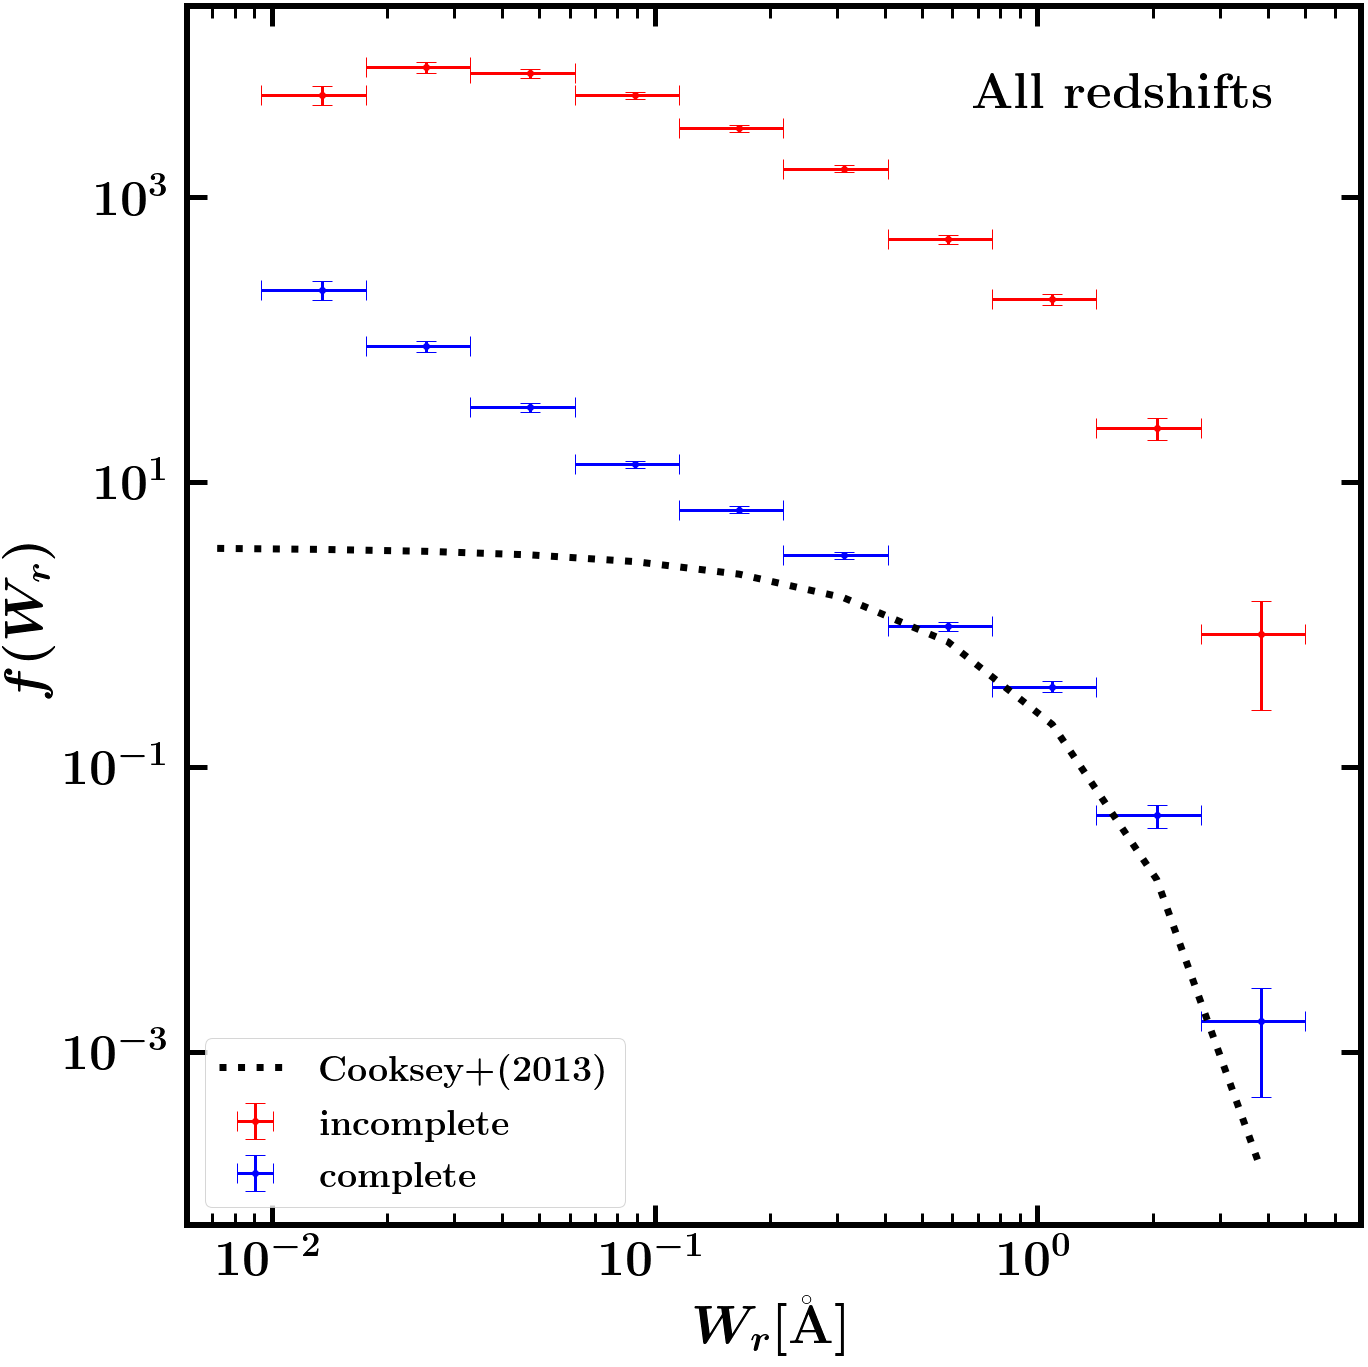

In [338]:
#Plot EWD:


fig, ax = plt.subplots(figsize=(20, 20))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)


plt.scatter(ewbins_plot[1:], EWD_array_in[1:], c='red', marker='.', s=100)
ax.errorbar(ewbins_plot[1:], EWD_array_in[1:], yerr=EWD_array_e_in[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, elinewidth=3,  c='red',
           label=r'\textbf{incomplete}')

ytest, ytest_e = [i/1e3 for i in EWD_array[1:]], [i/1e3 for i in EWD_array_e[1:]]

plt.scatter(ewbins_plot[1:], EWD_array[1:], c='blue', marker='.', s=100)
ax.errorbar(ewbins_plot[1:], EWD_array[1:], yerr=EWD_array_e[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, elinewidth=3,  c='blue',
           label=r'\textbf{complete}')


# plt.scatter(ewbins_plot[1:], EWD_array_f[1:], c='blue', marker='.', s=100)
# ax.errorbar(ewbins_plot[1:], EWD_array_f[1:], yerr=EWD_array_e_f[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, elinewidth=3,  c='blue',
#            label=r'\textbf{complete f(W)}')

# schfuncs = [ i for i in schechter(ewbins_plot[1:],-3,0.5,0.2)]

# schfuncs = []
# for e in ewbins_plot[1:]:
#     sc = schechter(e,-1.05,0.6,1.6)
#     schfuncs.append(sc)

# plt.plot(ewbins_plot,[schechter(i,-1.05,0.6,1.6) for i in ewbins_plot],ls='--',c='blue',lw=8)

# plt.plot(ewbins_plot,[schechter(i,fit_fw[0],fit_fw[1],fit_fw[2]) for i in ewbins_plot],ls='--',c='blue',lw=8)


#Other f(W) fits:

cooksey_k, cooksey_a = 3.49, -2.62
dodo_k, dodo_a = 3.72, -1.71

plt.plot(ewbins_plot,[fw_exp(cooksey_k, cooksey_a,i) for i in ewbins_plot],c='black',lw=7,ls=':',label=r'\textbf{Cooksey+(2013)}')

# plt.plot(ewbins_plot[1:],[fw_exp(dodo_k, dodo_a,i) for i in ewbins_plot[1:]],c='brown',lw=7,ls='-.',label=r'\textbf{Dodorico+(2010)}')


# plt.scatter(ewbins_plot[1:], EWD_norm[1:], c='black', marker='.', s=100)
# ax.errorbar(ewbins_plot[1:], EWD_norm[1:], yerr=EWD_norm_e[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, elinewidth=3,  c='black',
#            label=r'\textbf{complete f(W) + Normalized to dN/dX}')


# plt.scatter(ewbins_plot[1:], dNdX_norm[1:], c='maroon', marker='.', s=100)
# ax.errorbar(ewbins_plot[1:], dNdX_norm[1:], yerr=dNdX_norm_e[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, elinewidth=3,  c='maroon',
#            label=r'\textbf{dN/dX}')



ax.set_xlabel(r'\boldmath{$W_r[\mathrm{\AA{}}]$}',fontsize=54,labelpad=15)
ax.set_ylabel(r'\boldmath{$f(W_r)$}',fontsize=54,rotation=90)


# ax.set_yticks(np.arange(6e-3,1e1,10))
# ax.set_yticks(np.arange(1e-6,3e5,1), minor=True)


ax.set_yscale('log')
ax.set_xscale('log')


ax.tick_params(axis='both', which='major', direction='in', pad=15, labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', pad=15, labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')


# ax.set_xticks(np.arange(1,5,.5))


plt.xlim(6e-3,7)
# plt.ylim(1e-6,3e5)

# # plt.xlim(1.2,4.5)

fig.text(0.7,0.9,r'\textbf{All redshifts}',fontsize=50)


fig.tight_layout()

plt.legend(loc='lower left',fontsize=36,framealpha=None)

# plt.savefig('EWDs_new.pdf', dpi=200)

plt.show()

In [ ]:
#Plot EWD + completeness fraction:


fig, ax = plt.subplots(figsize=(20, 20))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)


ax.scatter(ewbins_plot, EWD_array_in_l, c='black', marker='.', s=100)
ax.errorbar(ewbins_plot, EWD_array_in_l, yerr=EWD_array_e_in_l, xerr=ewerr_plot, fmt='o', capsize=10, elinewidth=3,  c='black')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'\boldmath{$W_r[\mathrm{\AA{}}]$}',fontsize=54,labelpad=15)
ax.set_ylabel(r'\boldmath{$f(W_r)$}',fontsize=54,rotation=90)


ax.tick_params(axis='both', which='major', direction='in', pad=15, labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', pad=15, labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')



ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(ewbins_plot, fz_scaled_ew_bins[0], c='blue',lw=7,ls='-.',label=r'\textbf{completeness fraction}')
# ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='y', which='major', direction='in', pad=15, labelsize=50,length=20, width=5, right='on')
ax2.tick_params(axis='y', which='minor', direction='in', pad=15, labelsize=50,length=12, width=3,  right='on')

ax2.set_ylabel(r'\boldmath{$f_z$}',fontsize=54,labelpad=20,rotation=0)

ax2.set_yticks(np.arange(0,1,0.025),minor=True)


# ax.set_xticks(np.arange(1,5,.1), minor=True)
# ax.set_xticks(np.arange(1,5,.5))


# plt.ylim(1e-2,7e1)
# # plt.xlim(1.2,4.5)

fig.text(0.48,0.2,r'\textbf{All redshifts}',fontsize=50)


fig.tight_layout()

# plt.subplots_adjust(wspace=0, hspace=0)


plt.legend(loc='lower right',fontsize=40,framealpha=None)

# plt.savefig('EWD_in.pdf', dpi=200)

plt.show()

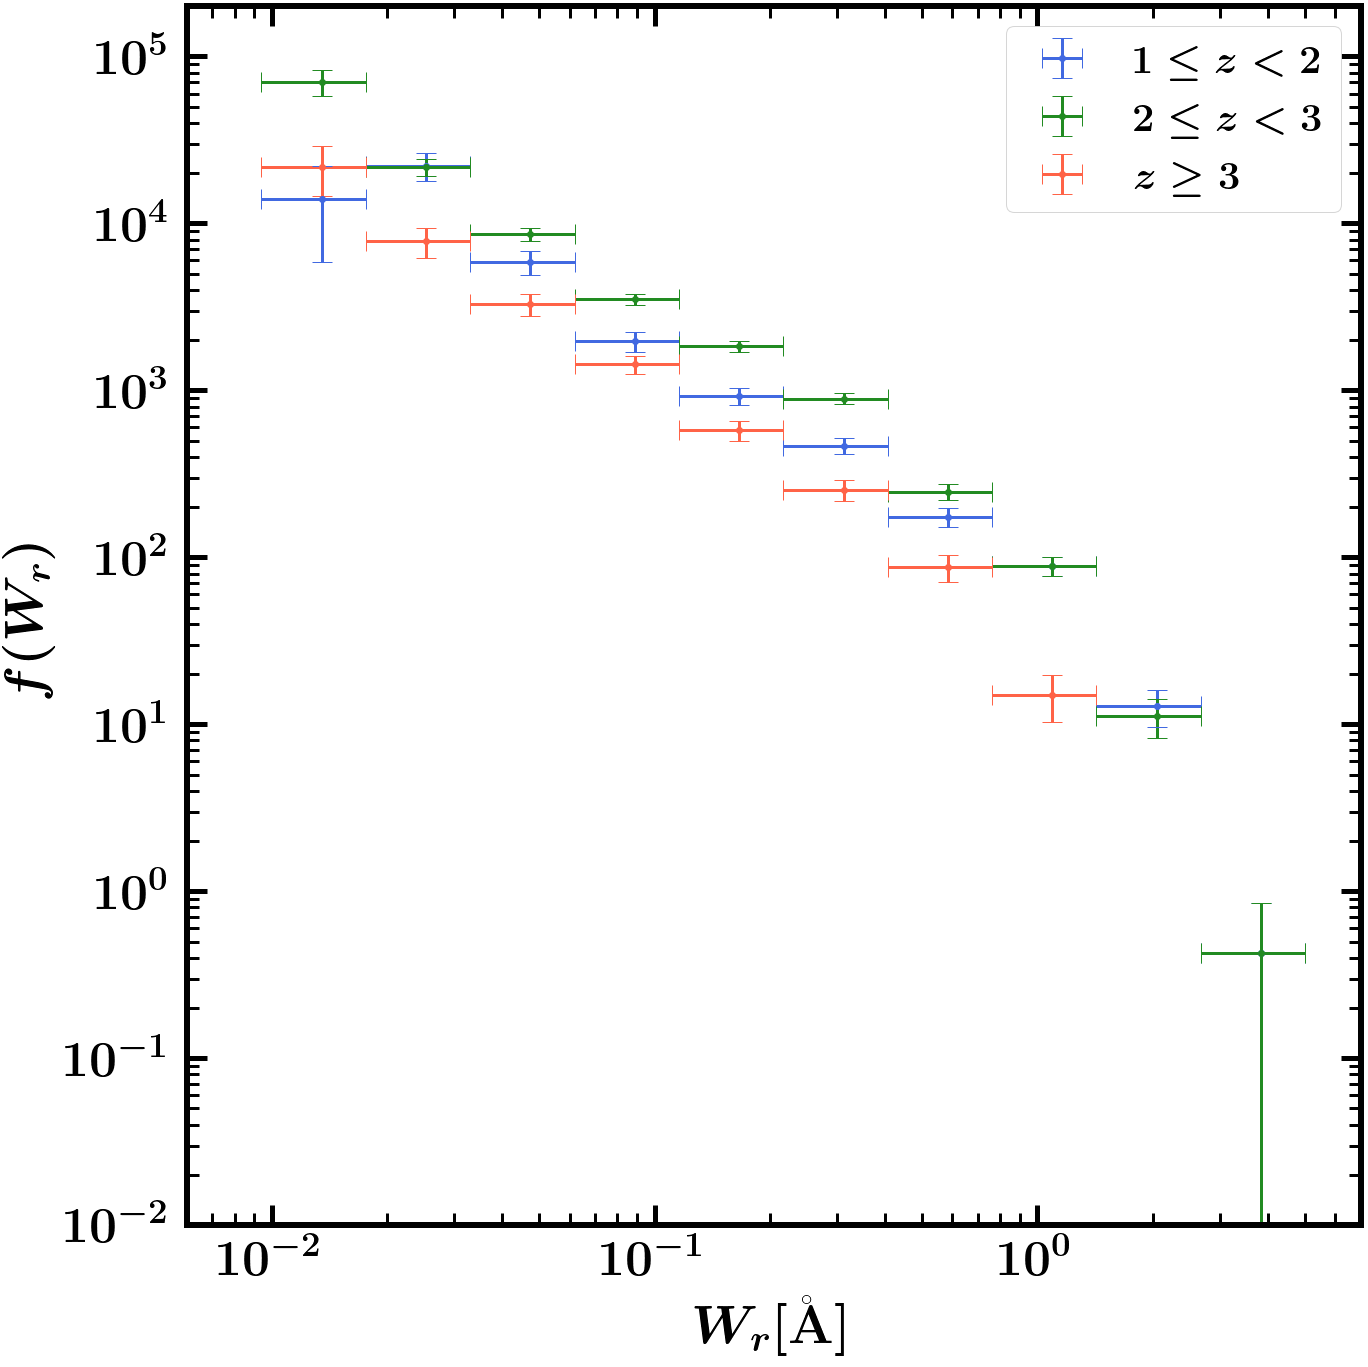

In [914]:
#Plot EWD for different redshift bins:


fig, ax = plt.subplots(figsize=(20, 20))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)


# plt.scatter(ewbins_plot[1:], EWD_array_in[1:], c='red', marker='.', s=100)
# ax.errorbar(ewbins_plot[1:], EWD_array_in[1:], yerr=EWD_array_e_in[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, elinewidth=3,  c='red',
#            label=r'\textbf{incomplete}')


plt.scatter(ewbins_plot[1:], EWD_array_l[1:], c='royalblue', marker='.', s=100)
ax.errorbar(ewbins_plot[1:], EWD_array_l[1:], yerr=EWD_array_e_l[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, 
            elinewidth=3,  c='royalblue', label=r'\boldmath{$1 \leq z < 2$}')


plt.scatter(ewbins_plot[1:], EWD_array_m[1:], c='forestgreen', marker='.', s=100)
ax.errorbar(ewbins_plot[1:], EWD_array_m[1:], yerr=EWD_array_e_m[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, 
            elinewidth=3,  c='forestgreen', label=r'\boldmath{$2 \leq z < 3$}')


plt.scatter(ewbins_plot[1:], EWD_array_h[1:], c='tomato', marker='.', s=100)
ax.errorbar(ewbins_plot[1:], EWD_array_h[1:], yerr=EWD_array_e_h[1:], xerr=ewerr_plot[1:], fmt='o', capsize=10, 
            elinewidth=3,  c='tomato', label=r'\boldmath{$z \geq 3$}')


# plt.scatter(zbins_plot, dNdz_plot_weak, c='black', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.3~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdz_plot_weak, yerr=dNdz_e_plot_weak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='black')

# plt.scatter(zbins_plot, dNdz_plot_med, c='red', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.6~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdz_plot_med, yerr=dNdz_e_plot_med, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='red')

# plt.scatter(zbins_plot, dNdz_plot_strong, c='blue', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.9~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdz_plot_strong, yerr=dNdz_e_plot_strong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='blue')


# plt.scatter(zbins_plot, dNdz_plot_vstrong, c='green', marker='o', s=100, label=r'\boldmath{$W_r \geq 1.2~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdz_plot_vstrong, yerr=dNdz_e_plot_vstrong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='green')



ax.set_xlabel(r'\boldmath{$W_r[\mathrm{\AA{}}]$}',fontsize=54,labelpad=15)
ax.set_ylabel(r'\boldmath{$f(W_r)$}',fontsize=54,rotation=90)

ax.set_yscale('log')
ax.set_xscale('log')


ax.tick_params(axis='both', which='major', direction='in', pad=15, labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', pad=15, labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')

# ax.set_xticks(np.arange(1,5,.1), minor=True)
# ax.set_xticks(np.arange(1,5,.5))


plt.xlim(6e-3,7)
plt.ylim(1e-2,2e5)

# fig.text(0.2,0.2,r'\textbf{All redshifts}',fontsize=50)


fig.tight_layout()

plt.legend(loc='best',fontsize=40,framealpha=None)

# plt.savefig('EWDs_zbins.pdf', dpi=200)

plt.show()

In [537]:
ewbins[-2]

2.674685524389081

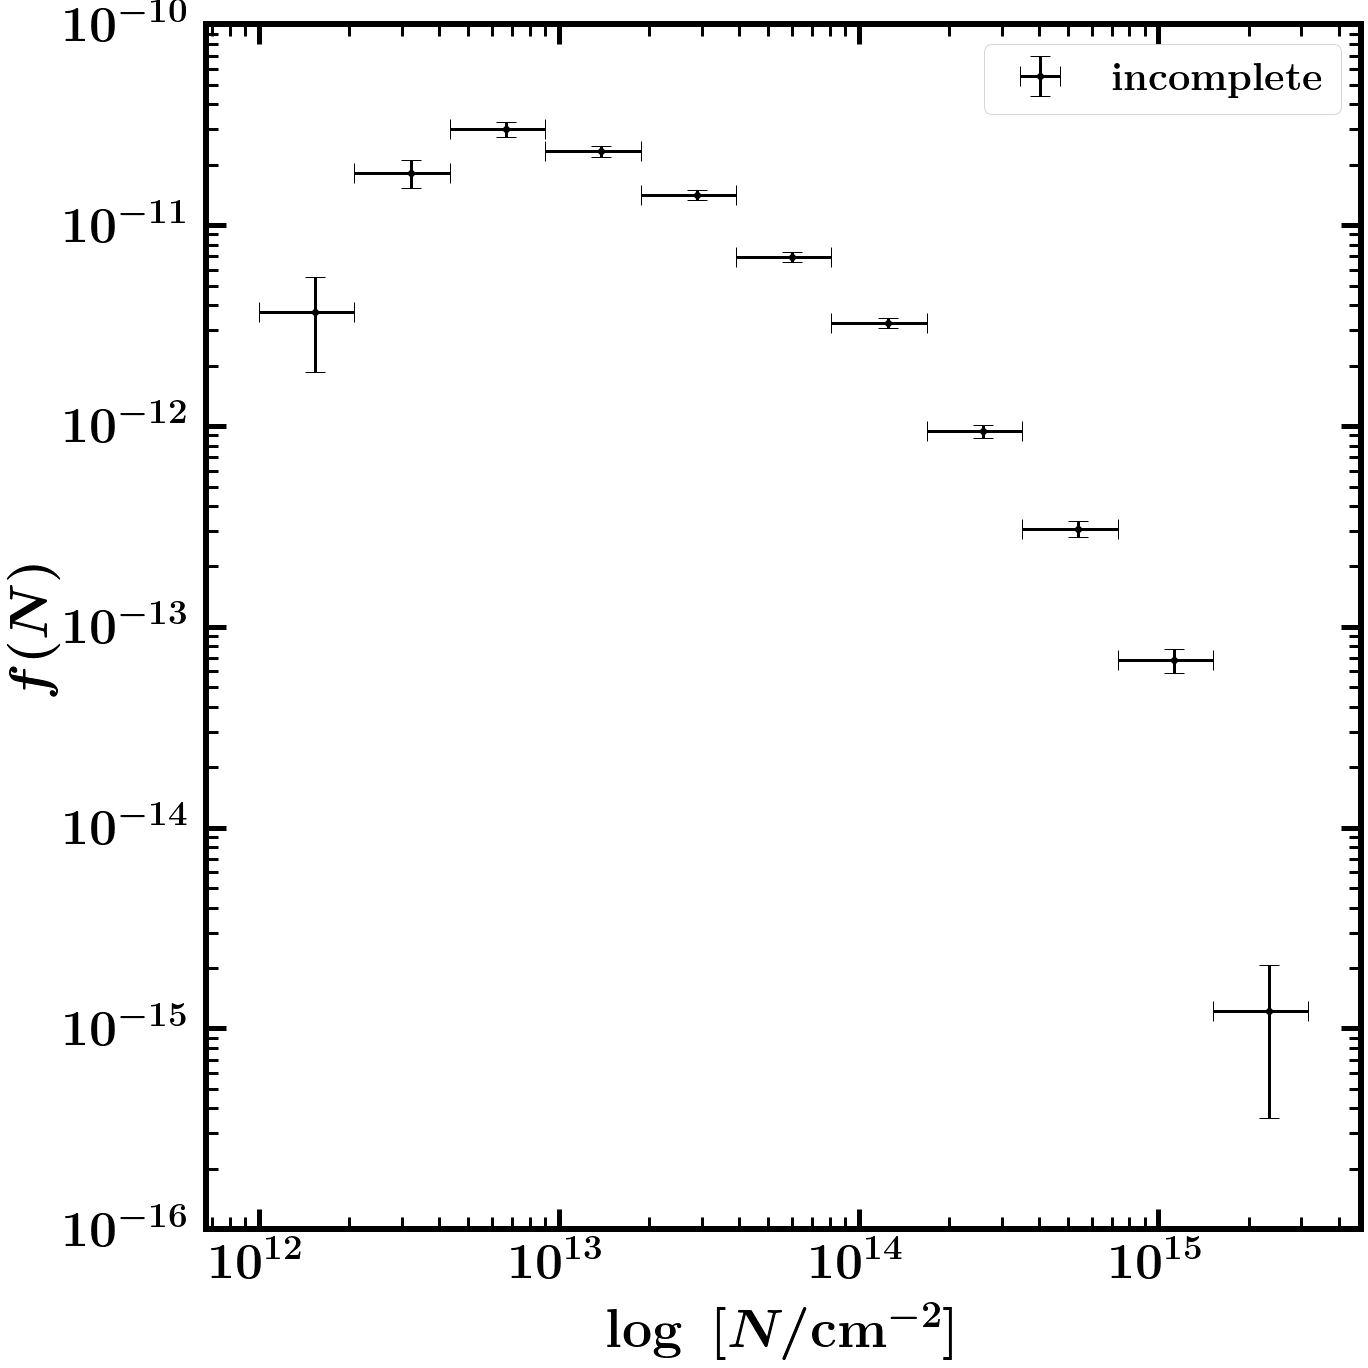

In [234]:
#Plot CDD:


fig, ax = plt.subplots(figsize=(20, 20))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)



plt.scatter(cdbins_plot, CDD_array_in, c='black', marker='.', s=100)
ax.errorbar(cdbins_plot, CDD_array_in, yerr=CDD_array_e_in, xerr=cderr_plot, fmt='o', capsize=10, elinewidth=3,  c='black',
           label=r'\textbf{incomplete}')




ax.set_xlabel(r'\boldmath{$\log ~[N/\mathrm{cm}^{-2}]$}',fontsize=54,labelpad=15)
ax.set_ylabel(r'\boldmath{$f(N)$}',fontsize=54,rotation=90)

ax.set_yscale('log')
ax.set_xscale('log')


ax.tick_params(axis='both', which='major', direction='in', pad=15, labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', pad=15, labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')

# ax.set_xticks(np.arange(1,5,.1), minor=True)
# ax.set_xticks(np.arange(1,5,.5))


plt.ylim(1e-16,1e-10)
# # plt.xlim(1.2,4.5)


plt.legend(loc='best',fontsize=40,framealpha=None)

fig.tight_layout()


# plt.savefig('CDD_in.pdf', dpi=200)

plt.show()

In [18]:
#new arrays for plotting:

# zbins_plot = np.array([1.55687,1.65971,1.73999,1.82360,1.91460,2.01778,2.15320,2.35608,2.72298,3.25860])
zbins_plot = []
zerr_plot = []

for i in range(len(zbins)-1):
    zbin0, zbin1 = zbins[i], zbins[i+1]
#     if i < 9:
#         zbin1 = zbins[i+1]
        
#     else:
#         zbin1 = 4.55
    
    mn = np.mean([zbin0,zbin1])    
    zbins_plot.append(mn)
    zerr_plot.append((zbin1-zbin0)/2)

#dN/dz:

dNdz_plot, dNdz_e_plot = dNdz_array, dNdz_e_array

dNdz_plot_vweak, dNdz_e_plot_vweak = dNdz_array_vweak, dNdz_e_array_vweak

dNdz_plot_weak, dNdz_e_plot_weak = dNdz_array_weak, dNdz_e_array_weak

dNdz_plot_med, dNdz_e_plot_med = dNdz_array_med, dNdz_e_array_med

dNdz_plot_strong, dNdz_e_plot_strong = dNdz_array_strong, dNdz_e_array_strong

dNdz_plot_vstrong, dNdz_e_plot_vstrong = dNdz_array_vstrong, dNdz_e_array_vstrong


#dN/dX:

dNdX_plot, dNdX_e_plot = dNdX_array, dNdX_e_array

dNdX_plot_vweak, dNdX_e_plot_vweak = dNdX_array_vweak, dNdX_e_array_vweak

dNdX_plot_weak, dNdX_e_plot_weak = dNdX_array_weak, dNdX_e_array_weak

dNdX_plot_med, dNdX_e_plot_med = dNdX_array_med, dNdX_e_array_med

dNdX_plot_strong, dNdX_e_plot_strong = dNdX_array_strong, dNdX_e_array_strong

dNdX_plot_vstrong, dNdX_e_plot_vstrong = dNdX_array_vstrong, dNdX_e_array_vstrong

In [25]:
len(zbins_plot), len(dNdz_plot_vweak)

(10, 10)

In [16]:
dNdz_plot_vweak

[38.54592821683181,
 12.03577066905439,
 15.240487721142221,
 19.47005437245443,
 17.438996678659986,
 37.258391370903546,
 29.133909559866254,
 22.032801261036628,
 16.58495017075674,
 14.894865605654054]

In [ ]:
#Plot dN/dz (my way):

# plt.style.use('classic')
# %matplotlib inline

fig, ax = plt.subplots(figsize=(20, 25))

#TeX up labels and text:

plt.rc("text", usetex=True)
# plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)
# , label=r'\boldmath{$0.01~\mathrm{\AA} \leq W_r < 0.3~\mathrm{\AA}$}'
# , label=r'\boldmath{$0.3~\mathrm{\AA} \leq W_r < 0.6~\mathrm{\AA}$}'
# , label=r'\boldmath{$0.6~\mathrm{\AA} \leq W_r < 0.9~\mathrm{\AA}$}'
# , label=r'\boldmath{0.9~\mathrm{\AA} \leq W_r < 1.2~\mathrm{\AA}}$}'
# , label=r'\boldmath{$W_r > 1.2~\mathrm{\AA}$}'

plt.scatter(zbins_plot, dNdz_plot_vweak, c='red', marker='o', s=100, label=r'\boldmath{$0.01~\mathrm{\AA} \leq W_r < 0.3~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_vweak, yerr=dNdz_e_plot_vweak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='red')

# plt.scatter(zbins_plot, dNdz_plot_weak, c='black', marker='o', s=100, label=r'\boldmath{$0.4~\mathrm{\AA} \leq W_r < 0.7~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdz_plot_weak, yerr=dNdz_e_plot_weak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='black')

plt.scatter(zbins_plot, dNdz_plot_med, c='green', marker='o', s=100, label=r'\boldmath{$0.3~\mathrm{\AA} \leq W_r < 1~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_med, yerr=dNdz_e_plot_med, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='green')

plt.scatter(zbins_plot, dNdz_plot_strong, c='blue', marker='o', s=100, label=r'\boldmath{$W_r \geq 1~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_strong, yerr=dNdz_e_plot_strong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='blue')

# plt.scatter(zbins_plot, dNdz_plot_vstrong, c='green', marker='o', s=100, label=r'\boldmath{$W_r > 1.2~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdz_plot_vstrong, yerr=dNdz_e_plot_vstrong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='green')




ax.set_xlabel(r'\boldmath{$z$}',fontsize=54)
ax.set_ylabel(r'\boldmath{$dN/dz$}',fontsize=54,rotation=90)

ax.set_yscale('log')

ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')

ax.set_xticks(np.arange(1,5,.1), minor=True)
ax.set_xticks(np.arange(1,5,.5))

# ax.set_yticks(np.arange(1e-2,1e1,0.1), minor=True)



# ax.get_xaxis().set_tick_params(direction='in',width=3,size=15, right=True)
# ax.get_yaxis().set_tick_params(direction='in',width=3,size=15, top=True)

# ax.tick_params(which = 'both', direction='out', length=10, width=3)

plt.ylim(1e-2,1e2)
# plt.xlim(1.2,4.5)


plt.legend(loc='best',fontsize=38,framealpha=None)

fig.tight_layout()

# plt.savefig('dNdz_btn.pdf', dpi=200)

plt.show()

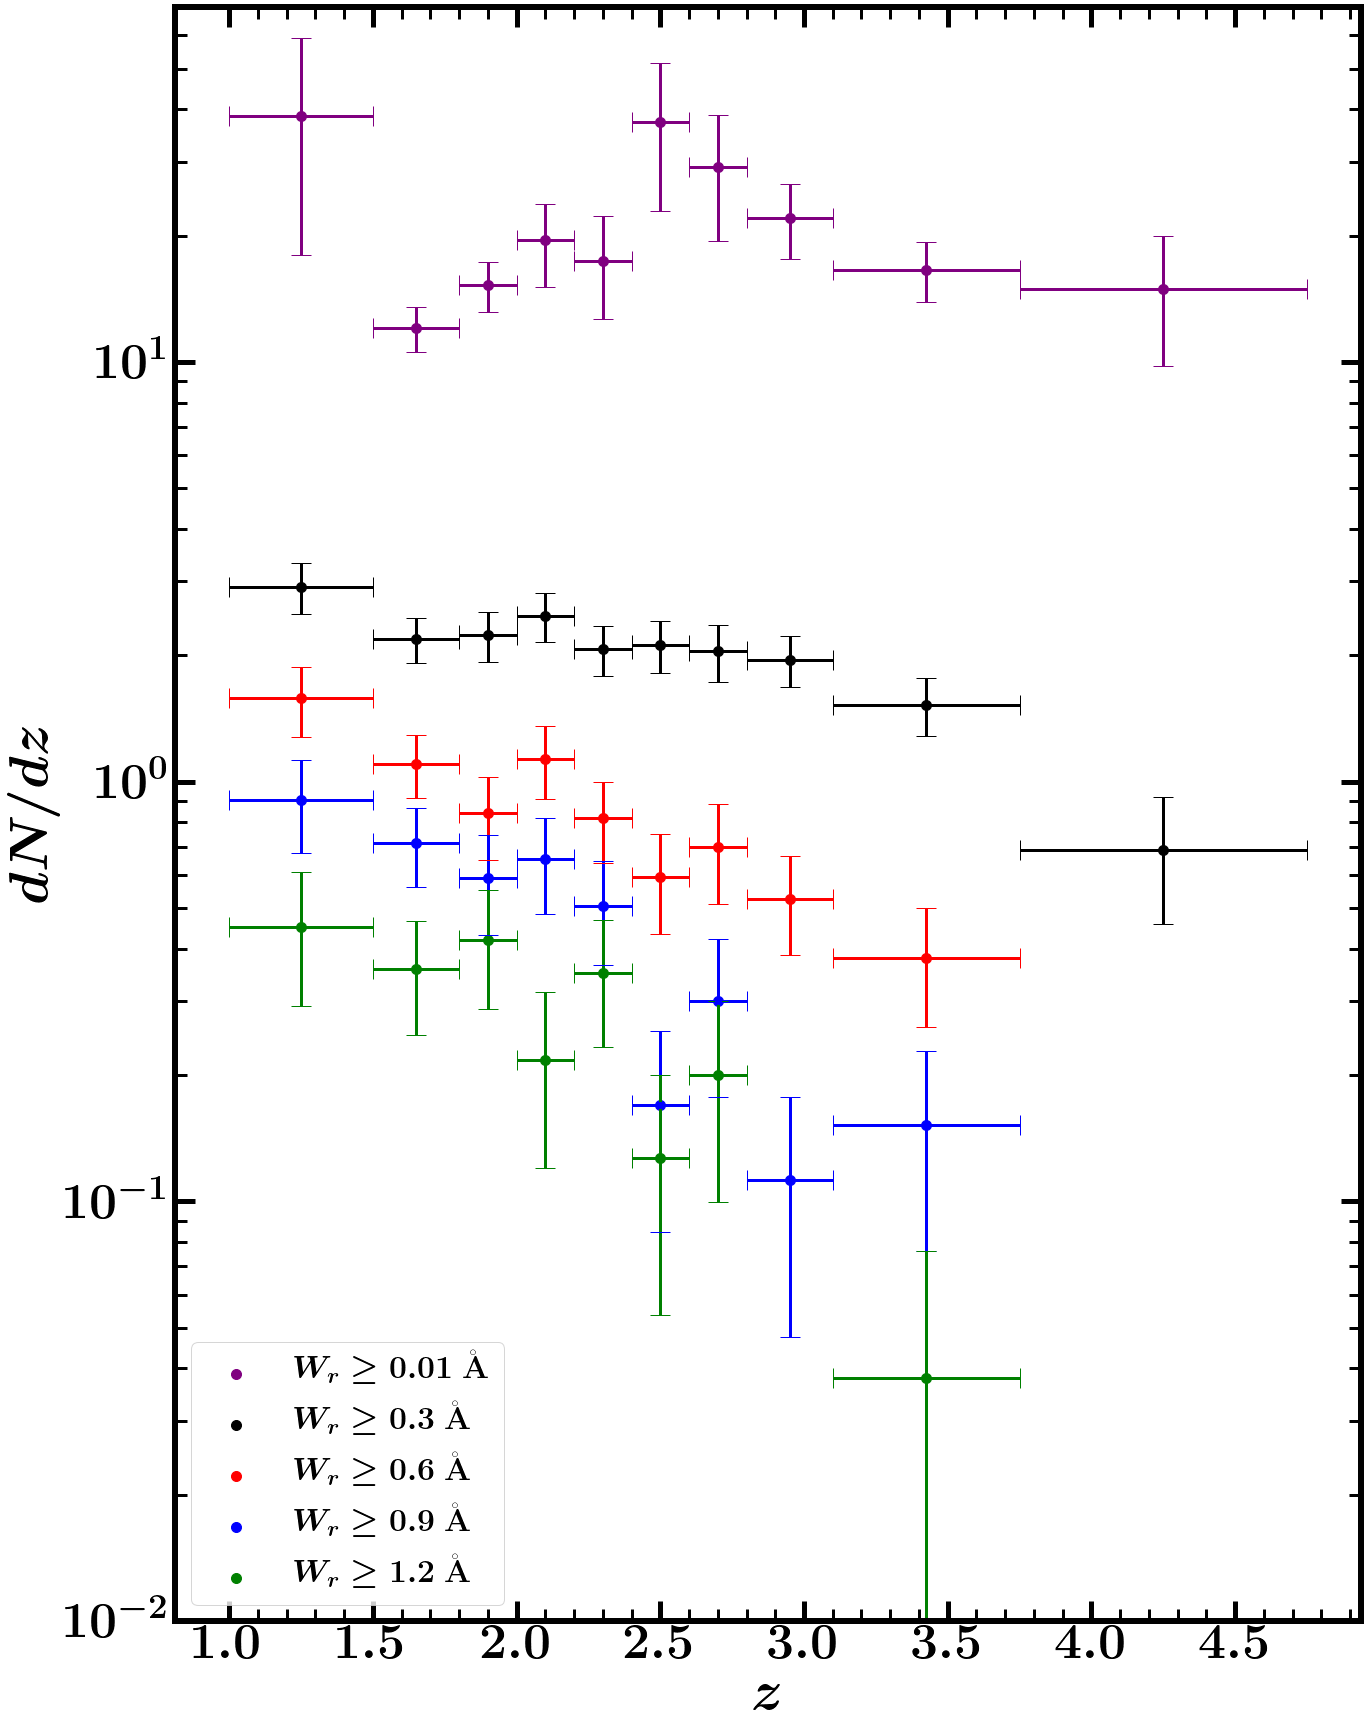

In [23]:
#Plot dN/dz (Cooksey-style):

# plt.style.use('classic')
# %matplotlib inline

fig, ax = plt.subplots(figsize=(20, 25))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)


plt.scatter(zbins_plot, dNdz_plot_vweak, c='purple', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.01~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_vweak, yerr=dNdz_e_plot_vweak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='purple')


plt.scatter(zbins_plot, dNdz_plot_weak, c='black', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.3~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_weak, yerr=dNdz_e_plot_weak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='black')

plt.scatter(zbins_plot, dNdz_plot_med, c='red', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.6~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_med, yerr=dNdz_e_plot_med, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='red')

plt.scatter(zbins_plot, dNdz_plot_strong, c='blue', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.9~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_strong, yerr=dNdz_e_plot_strong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='blue')


plt.scatter(zbins_plot, dNdz_plot_vstrong, c='green', marker='o', s=100, label=r'\boldmath{$W_r \geq 1.2~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdz_plot_vstrong, yerr=dNdz_e_plot_vstrong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='green')



ax.set_xlabel(r'\boldmath{$z$}',fontsize=54)
ax.set_ylabel(r'\boldmath{$dN/dz$}',fontsize=54,rotation=90)

ax.set_yscale('log')


ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')

ax.set_xticks(np.arange(1,5,.1), minor=True)
ax.set_xticks(np.arange(1,5,.5))


plt.ylim(1e-2,7e1)
# plt.xlim(1.2,4.5)


ax.legend(loc='best',fontsize=32,framealpha=None)

fig.tight_layout()

# plt.savefig('dNdz_uniques_c.pdf', dpi=200)

plt.show()

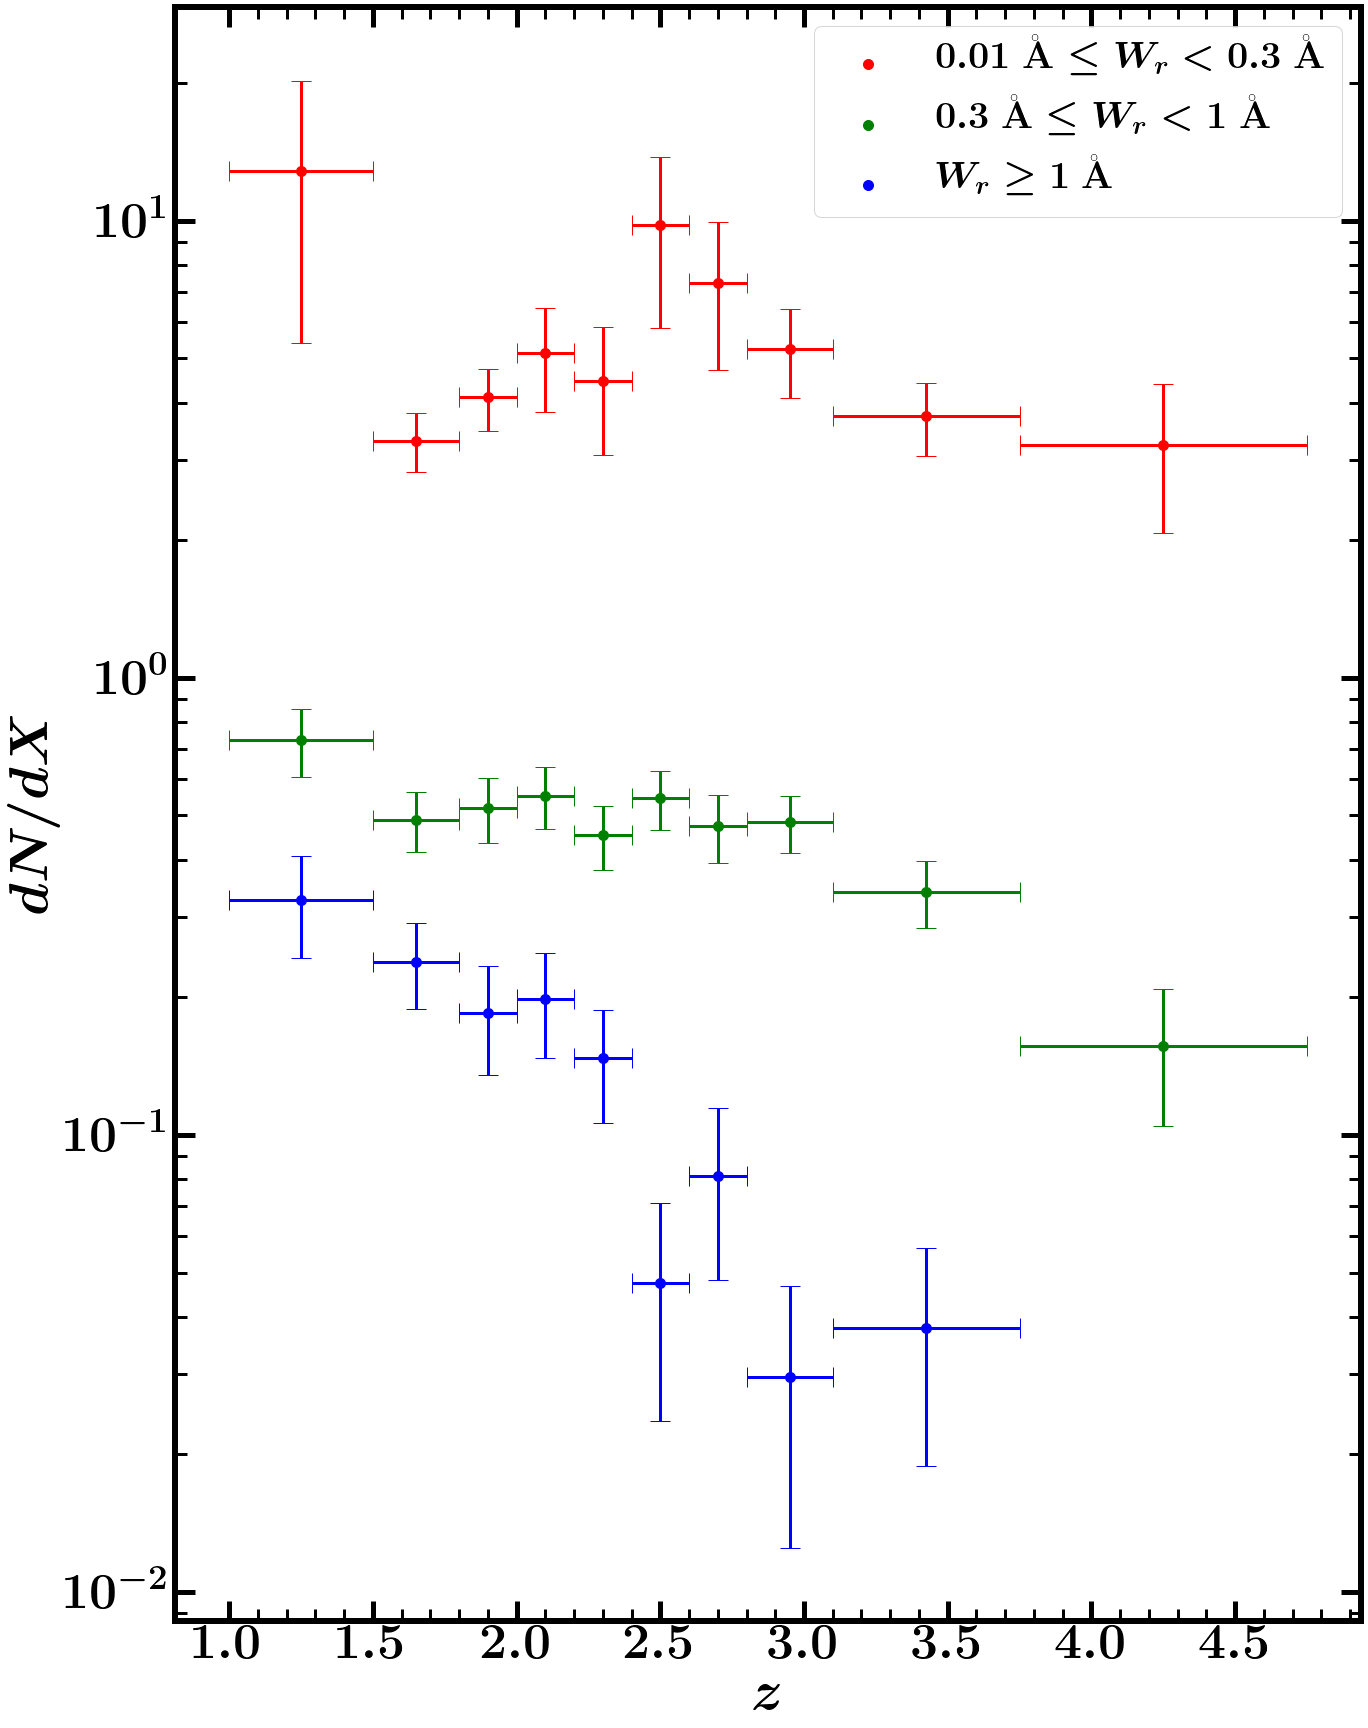

In [264]:
#Plot dN/dX (my way) 

# plt.style.use('classic')
# %matplotlib inline

fig, ax = plt.subplots(figsize=(20, 25))

#TeX up labels and text:


plt.rc("text", usetex=True)

plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)


# , label=r'\boldmath{$0.01~\mathrm{\AA} \leq W_r < 0.4~\mathrm{\AA}$}'
# , label=r'\boldmath{$0.4~\mathrm{\AA} \leq W_r < 0.7~\mathrm{\AA}$}'
# , label=r'\boldmath{$0.7~\mathrm{\AA} \leq W_r < 1~\mathrm{\AA}$}'
# , label=r'\boldmath{0.9~\mathrm{\AA} \leq W_r < 1.2~\mathrm{\AA}}$}'
# , label=r'\boldmath{$W_r > 1~\mathrm{\AA}$}'

plt.scatter(zbins_plot, dNdX_plot_vweak, c='red', marker='o', s=100, label=r'\boldmath{$0.01~\mathrm{\AA} \leq W_r < 0.3~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_vweak, yerr=dNdX_e_plot_vweak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='red')

# plt.scatter(zbins_plot, dNdX_plot_weak, c='black', marker='o', s=100, label=r'\boldmath{$0.4~\mathrm{\AA} \leq W_r < 0.7~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdX_plot_weak, yerr=dNdX_e_plot_weak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='black')


plt.scatter(zbins_plot, dNdX_plot_med, c='green', marker='o', s=100, label=r'\boldmath{$0.3~\mathrm{\AA} \leq W_r < 1~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_med, yerr=dNdX_e_plot_med, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='green')

plt.scatter(zbins_plot, dNdX_plot_strong, c='blue', marker='o', s=100, label=r'\boldmath{$W_r \geq 1~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_strong, yerr=dNdX_e_plot_strong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='blue')


# plt.scatter(zbins_plot, dNdX_plot_vstrong, c='green', marker='o', s=100, label=r'\boldmath{$W_r \geq 1.2~\mathrm{\AA}$}')
# ax.errorbar(zbins_plot, dNdX_plot_vstrong, yerr=dNdX_e_plot_vstrong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='green')



ax.set_xlabel(r'\boldmath{$z$}',fontsize=54)
ax.set_ylabel(r'\boldmath{$dN/dX$}',fontsize=54,rotation=90)

ax.set_yscale('log')


ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')

ax.set_xticks(np.arange(1,5,.1), minor=True)
ax.set_xticks(np.arange(1,5,.5))

# ax.set_yticks(np.arange(0,1.1,0.1), minor=True)

# ax.tick_params(axis='x', which='major', direction='in', labelsize=40,length=15, width=3)
# ax.tick_params(axis='x', which='minor', direction='in', labelsize=36,length=10, width=2)

# ax.get_xaxis().set_tick_params(direction='in',width=3,size=15, right=True)
# ax.get_yaxis().set_tick_params(direction='in',width=3,size=15, top=True)

# ax.tick_params(which = 'both', direction='out', length=10, width=3)

# plt.ylim(1e-3,1e2)
# plt.xlim(1.2,4.5)


ax.legend(loc='best',fontsize=38,framealpha=None)

fig.tight_layout()

# plt.savefig('dNdX_btn.pdf', dpi=200)

plt.show()

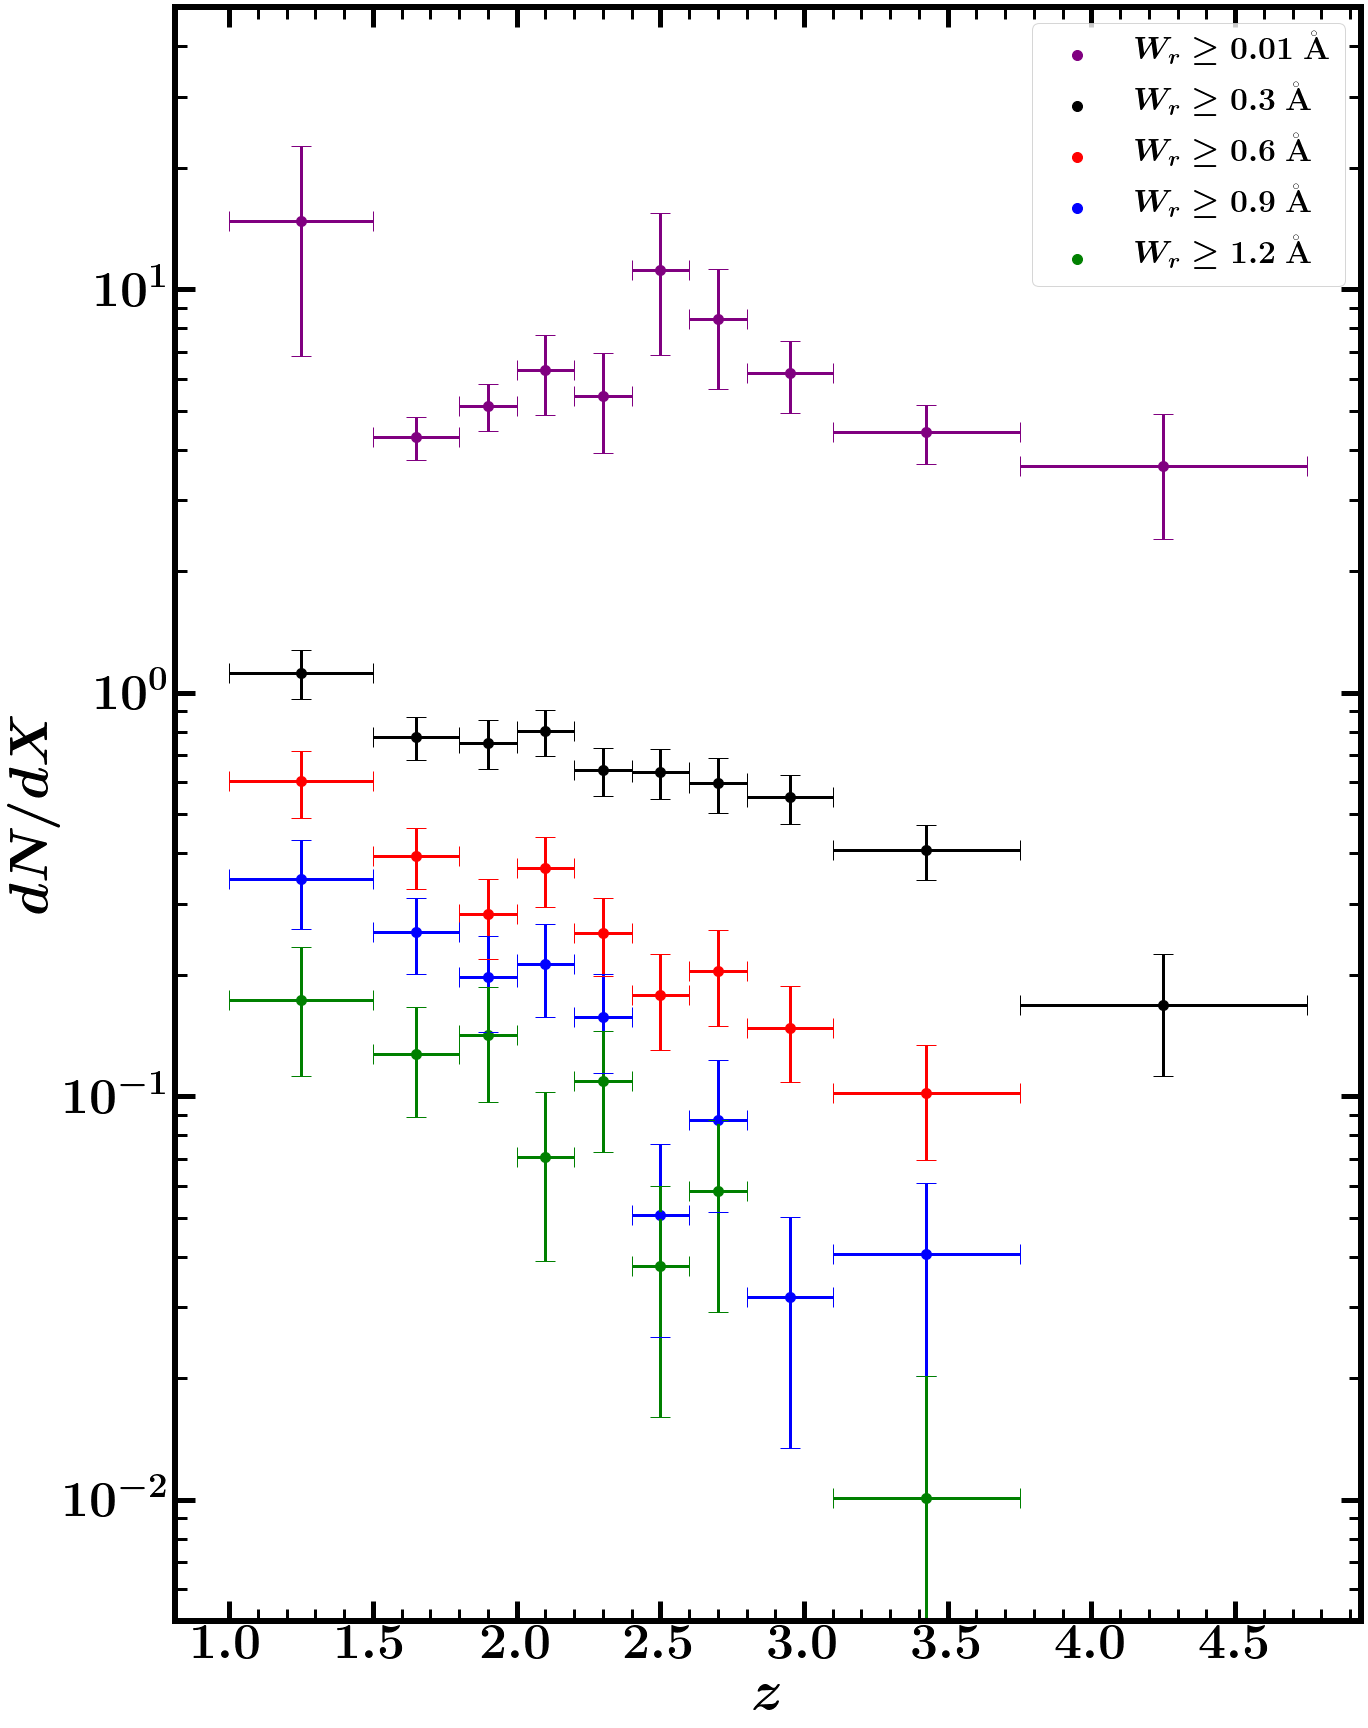

In [26]:
#Plot dN/dX (Cooksey-style):

# plt.style.use('classic')
# %matplotlib inline

fig, ax = plt.subplots(figsize=(20, 25))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)

# rc('axes', linewidth=4)


plt.scatter(zbins_plot, dNdX_plot_vweak, c='purple', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.01~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_vweak, yerr=dNdX_e_plot_vweak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='purple')


plt.scatter(zbins_plot, dNdX_plot_weak, c='black', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.3~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_weak, yerr=dNdX_e_plot_weak, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='black')

plt.scatter(zbins_plot, dNdX_plot_med, c='red', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.6~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_med, yerr=dNdX_e_plot_med, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='red')

plt.scatter(zbins_plot, dNdX_plot_strong, c='blue', marker='o', s=100, label=r'\boldmath{$W_r \geq 0.9~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_strong, yerr=dNdX_e_plot_strong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='blue')


plt.scatter(zbins_plot, dNdX_plot_vstrong, c='green', marker='o', s=100, label=r'\boldmath{$W_r \geq 1.2~\mathrm{\AA}$}')
ax.errorbar(zbins_plot, dNdX_plot_vstrong, yerr=dNdX_e_plot_vstrong, xerr=zerr_plot, fmt='o', capsize=10, elinewidth=3,  c='green')



ax.set_xlabel(r'\boldmath{$z$}',fontsize=54)
ax.set_ylabel(r'\boldmath{$dN/dX$}',fontsize=54,rotation=90)

ax.set_yscale('log')


ax.tick_params(axis='both', which='major', direction='in', labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')

ax.set_xticks(np.arange(1,5,.1), minor=True)
ax.set_xticks(np.arange(1,5,.5))


plt.ylim(5e-3,5e1)
# plt.xlim(1.2,4.5)


ax.legend(loc='best',fontsize=32,framealpha=None)

fig.tight_layout()

# plt.savefig('dNdX_uniques_c.pdf', dpi=200)

plt.show()

In [41]:
dNdX_array

[13.89309888521804,
 4.030775895380049,
 4.812142551066472,
 5.884623493990738,
 5.072411102953014,
 10.397377711548813,
 25.99677358897909,
 16.171830199896988,
 5.596035891487652,
 3.3928921483267604]

## Characteristic sizes of absorbers 

In [129]:
bet, alph, Lm, Ls, phis = 0.3, -1.33, 1.995e7, 5.546e9, 6.81e-3
# a, x = 2*beta+alpha+1, Lfrac
# gam = sc.gammainc(a, x)

betas = np.arange(0.2,0.41,0.05)
cover_fracs = np.array([0.25,0.5,0.5,0.9,0.9])

len(cover_fracs), len(betas)

(5, 5)

In [130]:
#try to compute sizes R*:

bet, alph, Lm, Ls, phis = 0.3, -1.33, 1.995e7, 5.546e9, 6.81e-3
# a, x = 2*beta+alpha+1, Lfrac
# gam = sc.gammainc(a, x)

# betas = np.arange(0.15,0.41,0.05)
# cover_fracs = np.arange(0.1,1,0.2)

def Rstar(alpha,beta,Lmin,Lstar,dNdX,phistar,fc):
    
    hubble = c_kms/H0
    Lfrac = Lmin/Lstar
    a, x = 2*beta+alpha+1, Lfrac
    gam = sc.gammainc(a, x)
    
    term1 = 1/(np.pi*hubble)
    
    term2 = dNdX/(phistar*fc)
    
    term3 = 1/(gam)
    
    Rs = np.sqrt(term1 * term2 * term3) #Mpc
    
    Rs_kpc = Rs * 1000 #kpc
    
    return Rs_kpc


R_vw = np.array([Rstar(alph,b,Lm,Ls,dNdX_array_all_vw[0],phis,a) for a,b in zip(cover_fracs,betas)])
R_w = np.array([Rstar(alph,b,Lm,Ls,dNdX_array_all_w[0],phis,a) for a,b in zip(cover_fracs,betas)])

R_vw, R_w

# tab = [(a,b,c,d) for a,b,c,d in zip(cover_fracs,betas,R_vw, R_w)]

tab = [[round(i,2) for i in cover_fracs],[round(i,2) for i in betas],[round(i,2) for i in R_vw], [round(i,2) for i in R_w]]

In [131]:
tab

[[0.25, 0.5, 0.5, 0.9, 0.9],
 [0.2, 0.25, 0.3, 0.35, 0.4],
 [127.23, 116.88, 152.84, 149.85, 198.15],
 [72.86, 66.94, 87.53, 85.82, 113.48]]

In [133]:
ascii.write(tab, format='latex', names=('$f_c$','$\\beta$','$R^{\star} (0.01 \leq W_r \leq 0.3)$ [kpc]','$R^{\star} (W_r \geq 0.3)$ [kpc]'))  

\begin{table}
\begin{tabular}{cccc}
$f_c$ & $\beta$ & $R^{\star} (0.01 \leq W_r \leq 0.3)$ [kpc] & $R^{\star} (W_r \geq 0.3)$ [kpc] \\
0.25 & 0.2 & 127.23 & 72.86 \\
0.5 & 0.25 & 116.88 & 66.94 \\
0.5 & 0.3 & 152.84 & 87.53 \\
0.9 & 0.35 & 149.85 & 85.82 \\
0.9 & 0.4 & 198.15 & 113.48 \\
\end{tabular}
\end{table}


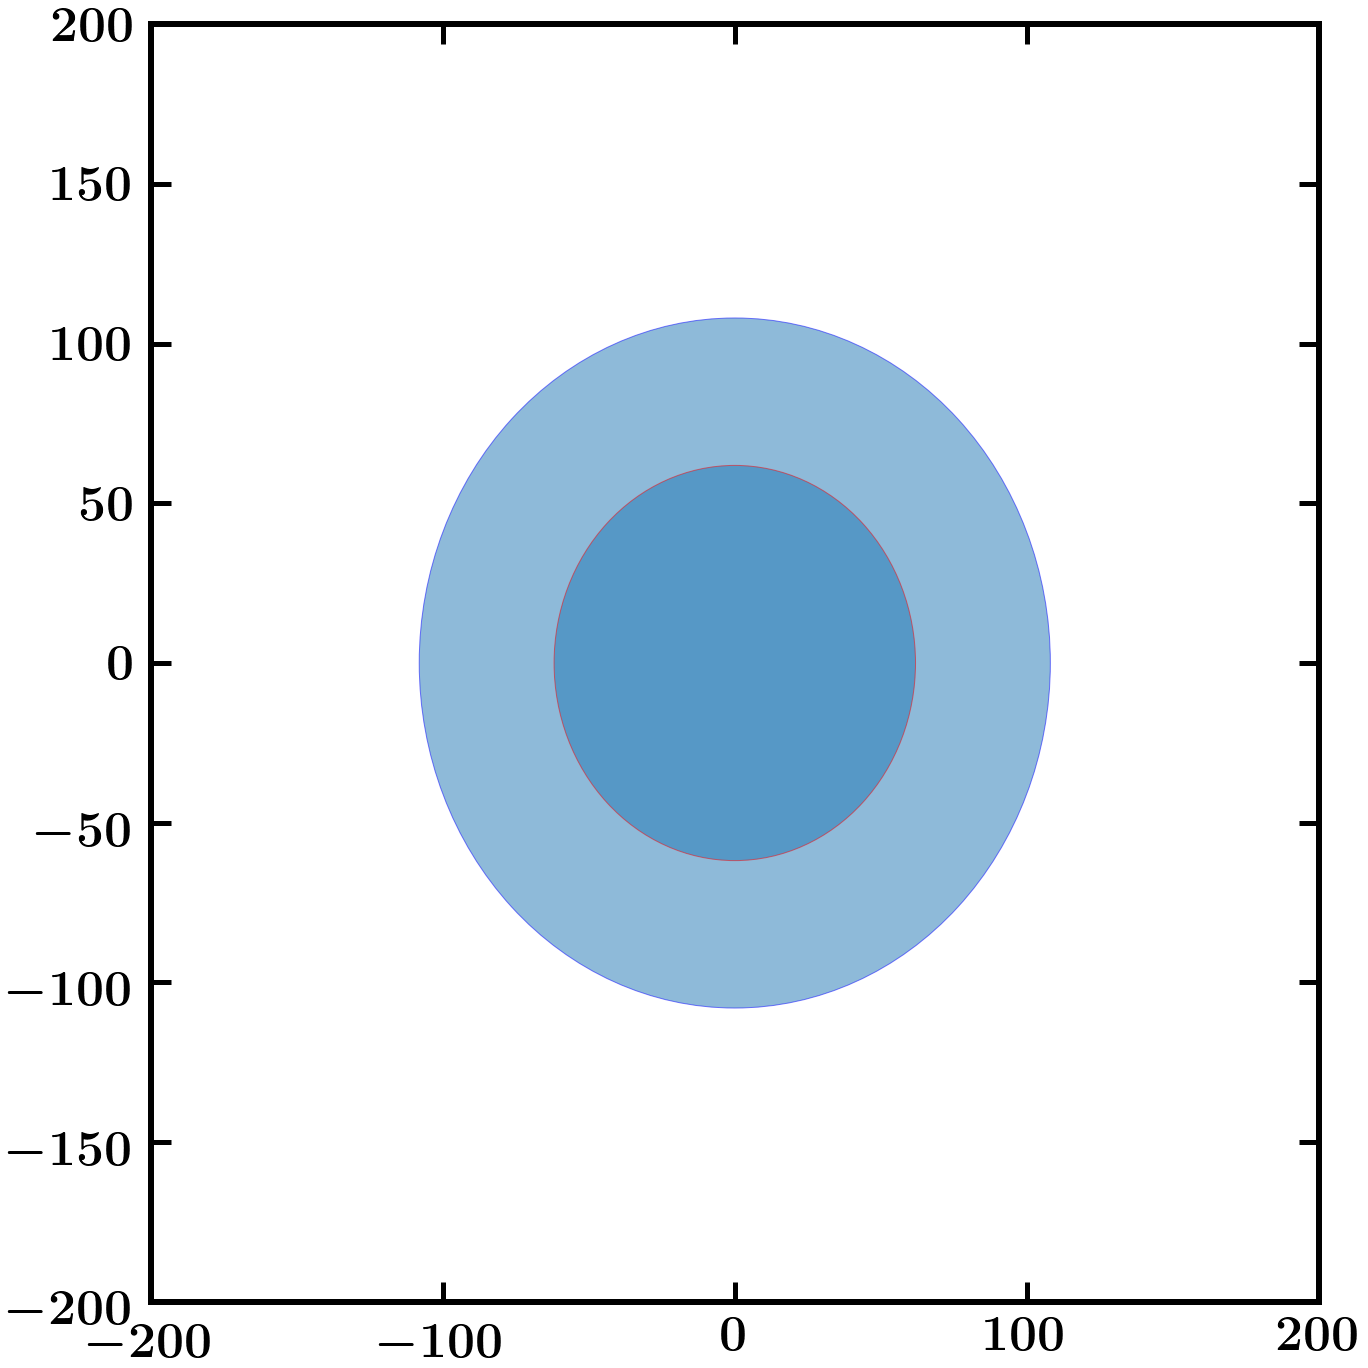

In [66]:
#Plot EWD for different redshift bins:


fig, ax = plt.subplots(figsize=(20, 20))

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=40) 
plt.rc('font', family='serif')

matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=6)


ax.add_patch(plt.Circle((0, 0), R_vw, edgecolor='blue', facecolor=None, alpha=0.5))
ax.add_patch(plt.Circle((0, 0), R_w, edgecolor='red', facecolor=None, alpha=0.5))


# ax.set_xlabel(r'\boldmath{$W_r[\mathrm{\AA{}}]$}',fontsize=54,labelpad=15)
# ax.set_ylabel(r'\boldmath{$f(W_r)$}',fontsize=54,rotation=90)

# ax.set_yscale('log')
# ax.set_xscale('log')


ax.tick_params(axis='both', which='major', direction='in', pad=15, labelsize=50,length=20, width=5, bottom='on',top='on', left='on', right='on')
ax.tick_params(axis='both', which='minor', direction='in', pad=15, labelsize=50,length=12, width=3, bottom='on',top='on', left='on', right='on')

# ax.set_xticks(np.arange(1,5,.1), minor=True)
# ax.set_xticks(np.arange(1,5,.5))


plt.xlim(-200,200)
plt.ylim(-200,200)

# fig.text(0.2,0.2,r'\textbf{All redshifts}',fontsize=50)


fig.tight_layout()

# plt.legend(loc='best',fontsize=40,framealpha=None)

# plt.savefig('EWDs_zbins.pdf', dpi=200)

plt.show()

In [ ]:
#ODR Method to find evolution parameter, cross section, and number density:


# Initiate some data, giving some randomness using random.random().
# x = np.array([0, 1, 2, 3, 4, 5])
# y = np.array([i**2 + random.random() for i in x])

# Define a function to fit the data with.
def line_density(p,z):
    n,sigma,eps = p
    f = n*sigma*(1+z)**eps
    return f

# Create a model for fitting.
linear_model = odr.Model(line_density)

guess = [7e-12, 1e11,0.5]
# Create a RealData object using our initiated data from above.
data = odr.RealData(zbins,dNdX_array)

# Set up ODR with the model and data.
reg = odr.ODR(data, linear_model, beta0=guess,maxit=2000)

# Run the regression.
out = reg.run()

# Use the in-built pprint method to give us results.
out.pprint()

## Nigel's architecture below (tread carefully) 

In [ ]:
# #EQW limit cut:

# cuts = [0.01,0.3,1.] #cuts of Wr>=0.01, 0.3, and 1 Angstrom

# binspacing = 0.3
# for cut in cuts:
#     eqwidths = CIV_data[3][np.where((CIV_data[3] >= cut))]
#     ewlims = CIV_data[2][np.where((CIV_data[3] >= cut))]
#     zabs = CIV_data[0][np.where((CIV_data[3] >= cut))]

#     print("Number of points: {}".format(len(eqwidths)))
    
#     #binspacing += 0.02
#     bins = np.arange(min(CIV_data[0]),max(CIV_data[0]),binspacing)
#     print(bins)
# #     bins = np.delete(bins,1)
# #     bins = np.delete(bins,-2)
# #     print(bins)

#     # Create histograms
#     hist,binedges = np.histogram(zabs,bins=bins)
#     binwidth = np.zeros(len(hist))
# #     print(hist)

#     deltaZhist = np.float64(np.copy(hist))
#     deltaXhist = np.float64(np.copy(hist))

#     histerr = np.float64(np.sqrt(hist))
#     deltaZhisterr = np.copy(histerr)
#     deltaXhisterr = np.copy(histerr)
    
#     for j,element in enumerate(hist):
#         binwidth[j] = binedges[j+1] - binedges[j]

#     # Find bin centers and bin widths
#     center = (binedges[:-1] + binedges[1:]) / 2
# #     print(eqwidths)

# # Calculate dN/dz:
#     for j in range(0,len(bins)-1):
#         subeqwidths = []
#         subzabs = []
#         subewlims = []
#         if (hist[j] == 0):
#             deltaZhist[j] = 0.
#             deltaXhist[j] = 0.
#             deltaZhisterr[j] = float('inf')
#             deltaXhisterr[j] = float('inf')
#             continue
#         subeqwidths = eqwidths[np.where((eqwidths >= bins[j]) & (eqwidths < bins[j+1]))]
#         subzabs = zabs[np.where((eqwidths >= bins[j]) & (eqwidths < bins[j+1]))]
#         # Divide each detection by the total redshift path (delta_Z = integral(g(W,z)dz))
#         delta_Z_inbin = 0.
#         delta_X_inbin = 0.
#         delta_Z_inbin_err = 0.
#         delta_X_inbin_err = 0.

#         print(subzabs)

# #     for n,ew in enumerate(subeqwidths):
# #         index = np.where(w_grid == find_nearest(w_grid,ew))[0][0]
# #         delta_Z = np.trapz(CIV_gwz[index],CIV_z_grid)
# #         delta_X = (1.+subzabs[n])**2 / np.sqrt(OMEGA_M * (1.+subzabs[n])**3 + OMEGA_L) * delta_Z
# #         delta_Z_inbin += 1./delta_Z
# #         delta_X_inbin += 1./delta_X
# #         delta_Z_inbin_err += (1./delta_Z)**2
# #         delta_X_inbin_err += (1./delta_X)**2

# #     # Calculate completeness and add the correction factor to the hist bin
# #     deltaZhist[j] = delta_Z_inbin
# #     deltaXhist[j] = delta_X_inbin
# #     deltaZhisterr[j] = np.sqrt(delta_Z_inbin_err)
# #     deltaXhisterr[j] = np.sqrt(delta_X_inbin_err)

# #     # Convert hists to 64 bit arrays

# # Nhist = np.float64(Nhist)
# # Nhisterr = np.float64(Nhisterr)
# # binwidth = np.zeros(len(hist))
# # # Divide by bin width for all arrays
# # for j,element in enumerate(hist):
# #     binwidth[j] = binedges[j+1] - binedges[j]

# #     Nhisterr[j] = float(Nhisterr[j]) / float(binwidth[j])
# #     Nhist[j] = float(Nhist[j]) / float(binwidth[j])

# #     deltaZhist[j] = float(deltaZhist[j]) / float(binwidth[j])
# #     deltaZhisterr[j] = float(deltaZhisterr[j]) / float(binwidth[j])

# #     deltaXhist[j] = float(deltaXhist[j]) / float(binwidth[j])
# #     deltaXhisterr[j] = float(deltaXhisterr[j]) / float(binwidth[j])

# #     if deltaZhist[j] - deltaZhisterr[j] < 1.e-4:
# #         deltaZhisterr[j] = deltaZhist[j] * 0.9
# #         deltaXhisterr[j] = deltaXhist[j] * 0.9

In [ ]:
# np.where((eqwidths >= bins[0]) & (eqwidths < bins[0+1]))